# TinyTimeMixer (TTM) using single dataset - ETTh2



In [1]:
# Install the tsfm library
# ! pip install "granite-tsfm[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.22"

## Imports

In [2]:
import math
import os
import tempfile

import pandas as pd
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
from transformers.integrations import INTEGRATION_TO_CALLBACK
from sklearn.metrics import mean_squared_error
import numpy as np
import pickle

from tsfm_public import TimeSeriesPreprocessor, TrackingCallback, count_parameters, get_datasets, TinyTimeMixerForPrediction
from tsfm_public.toolkit.get_model import get_model
from tsfm_public.toolkit.lr_finder import optimal_lr_finder
from tsfm_public.toolkit.visualization import plot_predictions
import matplotlib.pyplot as plt

In [ ]:
import warnings


# Suppress all warnings
warnings.filterwarnings("ignore")

### Helper functions

In [17]:
# function for comparing the predicted values with actual values at a particular point in time (For ex: At 12/24/48 hrs from current time...)

def compare_forecast(forecast, date_col, prediction_col, actual_col, hours_out):

  comparisons = pd.DataFrame()
  comparisons[date_col] = forecast[date_col]
  actual = []
  pred = []

  for i in range(len(forecast)):
    pred.append(forecast[prediction_col].values[i][hours_out - 1]) # prediction for next day
    actual.append(forecast[actual_col].values[i][hours_out - 1])

  comparisons['actual'] = actual
  comparisons['pred'] = pred

  return comparisons

def construct_output_df(data, model_trainer):

    preds = model_trainer.predict(data)
    
    output_dict = {
        "date": [],
        "actual": [],
        "pred" : [],
        "context": [],
        "full_window": [],
    }      

    for i in range(len(data)):
        ts = data[i]["timestamp"]
        fv = data[i]["future_values"].numpy().flatten()
        pv = data[i]["past_values"].numpy().flatten()
        w = np.concatenate([pv, fv])

        output_dict["date"].append(ts)
        output_dict["actual"].append(list(fv))
        output_dict["context"].append(list(pv))
        output_dict["full_window"].append(list(w))

    # extracting zero shot predictions on val/test data
    for i in range(len(preds.predictions[0])):
        pred = preds.predictions[0][i].flatten()
        output_dict["pred"].append(list(pred))

    output_df = pd.DataFrame({
        "date": output_dict["date"],
        "prediction": output_dict["pred"],
        "actual": output_dict["actual"],
        "context": output_dict["context"],
        "full_window" : output_dict["full_window"],
    })
    return output_df

def plot_high_error_samples(rows, cols, df, error_threshold):

    indices = df.index[df["error"] > error_threshold].tolist()
    rand_indices = np.random.choice(indices, size=rows*cols, replace=False)

    fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
    axes = axes.flatten()

    for j, idx in enumerate(rand_indices):
        plot_df = pd.DataFrame({
            "pred": df.iloc[idx]['prediction'],
            "actual": df.iloc[idx]['actual']
        })
        axes[j].plot(plot_df)
        axes[j].set_title(f"Index {idx}")

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right")

    plt.tight_layout()
    plt.show()

def load_shapelet(base_path, dataset):

    file_path = os.path.join(base_path, f'{dataset}.pkl')
    with open(file_path, 'rb') as handle:
        a_dict = pickle.load(handle)
    
    return(pd.DataFrame(a_dict.values()).transpose())

def get_top_k_timestamps_per_cluster(df, k=3, ascending=False):
    results = {}
    results_list = []
    for cluster_id in df["cluster"].unique():
        subset = df[df["cluster"] == cluster_id]
        if ascending:
            top_k = subset.nsmallest(k, "distance")
        else:
            top_k = subset.nlargest(k, "distance")
        results[cluster_id] = top_k["timestamp"].tolist()
        results_list.extend(top_k["timestamp"].tolist())
    return results, results_list


### Important arguments

In [2]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)


TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"

CONTEXT_LENGTH = 512
PREDICTION_LENGTH = 96
BATCH_SIZE = 64

TARGET_DATASET = "etth2"
dataset_path = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh2.csv"


# Results dir
OUT_DIR = "ttm_finetuned_models/"

# Data processing

In [4]:
# Dataset
TARGET_DATASET = "etth2"
dataset_path = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh2.csv"
timestamp_column = "date"
id_columns = []  # mention the ids that uniquely identify a time-series.

target_columns = ['OT']
# observable_columns = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL"]
split_config = {
    "train": [0, 8640],
    "valid": [8640, 11520],
    "test": [
        11520,
        14400,
    ],
}
# Understanding the split config -- slides

data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
    "observable_columns": []
}

## Zero-shot evaluation method

In [5]:
def zeroshot_eval(dataset_name, batch_size, context_length=512, forecast_length=96):
    # Get data

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )

    # Load model
    zeroshot_model = get_model(
        TTM_MODEL_PATH,
        context_length=context_length,
        prediction_length=forecast_length,
        freq_prefix_tuning=False,
        freq=None,
        prefer_l1_loss=False,
        prefer_longer_context=True,
        # Can also provide TTM Config args
        # prediction_channel_indices=tsp.prediction_channel_indices,
        # num_input_channels=tsp.num_input_channels
    )

    dset_train, dset_valid, dset_test = get_datasets(
        tsp, data, split_config, use_frequency_token=zeroshot_model.config.resolution_prefix_tuning
    )

    temp_dir = tempfile.mkdtemp()
    # zeroshot_trainer
    zeroshot_trainer = Trainer(
        model=zeroshot_model,
        args=TrainingArguments(
            output_dir=temp_dir,
            per_device_eval_batch_size=batch_size,
            seed=SEED,
            report_to="none",
        ),
    )
    # evaluate = zero-shot performance
    print("+" * 20, "Test MSE zero-shot", "+" * 20)
    zeroshot_output = zeroshot_trainer.evaluate(dset_test)
    print("zeroshot output returned from evaluate() function", zeroshot_output)

    # get predictions

    predictions_dict = zeroshot_trainer.predict(dset_test)
    print("zeroshot output returned from predict() function", predictions_dict[2])

    predictions_np = predictions_dict.predictions[0]

    print("shape of predictions array", predictions_np.shape)

    # get backbone embeddings (if needed for further analysis)

    backbone_embedding = predictions_dict.predictions[1]

    print("Backbone embedding shape", backbone_embedding.shape)

    # plot
    plot_predictions(
        model=zeroshot_trainer.model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_zeroshot",
        indices=[685, 118, 902],
        channel=0,
    )
    return predictions_dict

# Zeroshot

INFO:p-94226:t-8466403200:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:p-94226:t-8466403200:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-94226:t-8466403200:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96
/opt/homebrew/Caskroom/miniforge/base/envs/ttm_env_new3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


zeroshot output returned from evaluate() function {'eval_loss': 0.1306770145893097, 'eval_model_preparation_time': 0.0011, 'eval_runtime': 1.1379, 'eval_samples_per_second': 2447.506, 'eval_steps_per_second': 38.668}
zeroshot output returned from predict() function {'test_loss': 0.1306770145893097, 'test_model_preparation_time': 0.0011, 'test_runtime': 1.304, 'test_samples_per_second': 2135.782, 'test_steps_per_second': 33.743}
shape of predictions array (2785, 96, 1)
Backbone embedding shape (2785, 1, 8, 192)


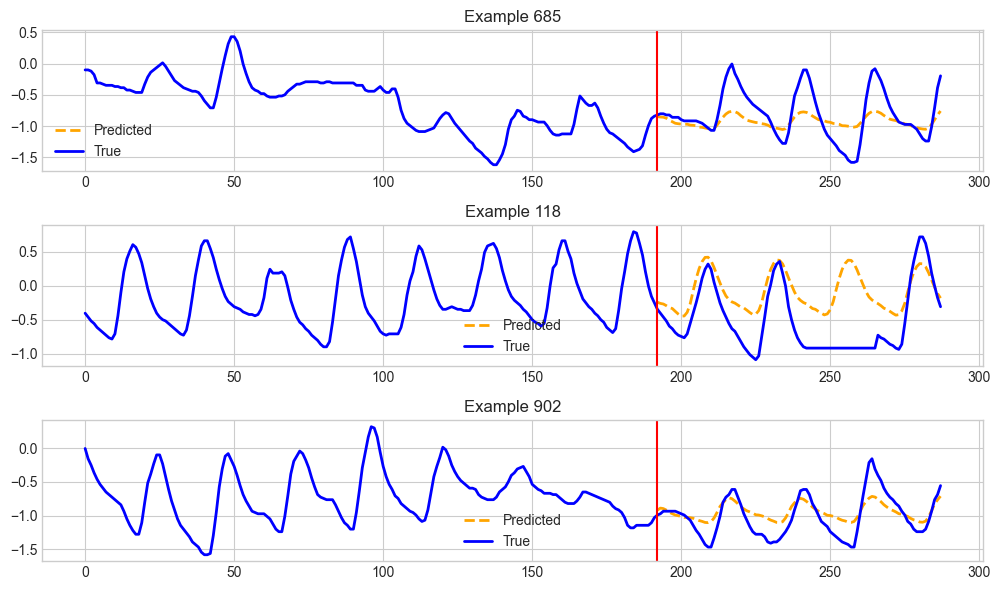

In [6]:
predictions_dict = zeroshot_eval(
    dataset_name=TARGET_DATASET, context_length=CONTEXT_LENGTH, forecast_length=PREDICTION_LENGTH, batch_size=64
)

 ## Few-shot finetune and evaluation method

In [8]:
def fewshot_finetune_eval(
    dataset_name,
    batch_size,
    learning_rate=None,
    context_length=512,
    forecast_length=96,
    fewshot_percent=100,
    freeze_backbone=True,
    num_epochs=10,
    save_dir=OUT_DIR,
    loss="mse",
    quantile=0.5,
):
    out_dir = os.path.join(save_dir, dataset_name)

    print("-" * 20, f"Running few-shot {fewshot_percent}%", "-" * 20)

    # Data prep: Get dataset
    

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )
    print("+" * 20, "TSP values", "+" * 20)
    print(tsp.prediction_channel_indices)
    print(tsp.exogenous_channel_indices)
    print(tsp.context_length)
    print(tsp.prediction_length)
    print(tsp.num_input_channels)
    print(tsp.scaler_type)




    # change head dropout to 0.7 for ett datasets
    if "ett" in dataset_name:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            # Can also provide TTM Config args
            prediction_channel_indices=tsp.prediction_channel_indices,
            num_input_channels=tsp.num_input_channels,

            head_dropout=0.7,
            loss=loss,
            quantile=quantile,
        )
    else:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            # Can also provide TTM Config args
            loss=loss,
            quantile=quantile,
        )

    dset_train, dset_val, dset_test = get_datasets(
        tsp,
        data,
        split_config,
        fewshot_fraction=fewshot_percent / 100,
        fewshot_location="first",
        use_frequency_token=finetune_forecast_model.config.resolution_prefix_tuning,
        
    )
    print("after get_datasets ------", len(dset_train))

    if freeze_backbone:
        print(
            "Number of params before freezing backbone",
            count_parameters(finetune_forecast_model),
        )

        # Freeze the backbone of the model
        for param in finetune_forecast_model.backbone.parameters():
            param.requires_grad = False

        # Count params
        print(
            "Number of params after freezing the backbone",
            count_parameters(finetune_forecast_model),
        )

    # Find optimal learning rate
    # Use with caution: Set it manually if the suggested learning rate is not suitable
    if learning_rate is None:
        learning_rate, finetune_forecast_model = optimal_lr_finder(
            finetune_forecast_model,
            dset_train,
            batch_size=batch_size,
        )
        print("OPTIMAL SUGGESTED LEARNING RATE =", learning_rate)

    print(f"Using learning rate = {learning_rate}")
    finetune_forecast_args = TrainingArguments(
        output_dir=os.path.join(out_dir, "v1_fft"),
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        do_eval=True,
        eval_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=8,
        report_to="none",
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=1,
        logging_dir=os.path.join(out_dir, "logs"),  # Make sure to specify a logging directory
        load_best_model_at_end=True,  # Load the best model when training ends
        metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
        greater_is_better=False,  # For loss
        seed=SEED,
    )

    # Create the early stopping callback
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=5,  # Number of epochs with no improvement after which to stop
        early_stopping_threshold=1e-5,  # Minimum improvement required to consider as improvement
    )
    tracking_callback = TrackingCallback()

    # Optimizer and scheduler
    optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
    scheduler = OneCycleLR(
        optimizer,
        learning_rate,
        epochs=num_epochs,
        steps_per_epoch=math.ceil(len(dset_train) / (batch_size)),
    )

    finetune_forecast_trainer = Trainer(
        model=finetune_forecast_model,
        args=finetune_forecast_args,
        train_dataset=dset_train,
        eval_dataset=dset_val,
        callbacks=[early_stopping_callback, tracking_callback],
        optimizers=(optimizer, scheduler),
    )
    finetune_forecast_trainer.remove_callback(INTEGRATION_TO_CALLBACK["codecarbon"])

    # Fine tune
    finetune_forecast_trainer.train()

    # Evaluation
    print("+" * 20, f"Test MSE after few-shot {fewshot_percent}% fine-tuning", "+" * 20)

    finetune_forecast_trainer.model.loss = "mse"  # fixing metric to mse for evaluation

    fewshot_output = finetune_forecast_trainer.evaluate(dset_test)
    print(fewshot_output)
    print("+" * 60)

    # get predictions

    predictions_dict = finetune_forecast_trainer.predict(dset_test)
    print("prediction metrics on test set", predictions_dict[2])

    predictions_np = predictions_dict.predictions[0]

    print(predictions_np.shape)

    # get backbone embeddings (if needed for further analysis)

    backbone_embedding = predictions_dict.predictions[1]

    print(backbone_embedding.shape)

    # plot
    plot_predictions(
        model=finetune_forecast_trainer.model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_fewshot",
        indices=[685, 118, 902],
        channel=0,
    )
    return predictions_dict

### Fine-tuning on full dataset (using 100% train split)

INFO:p-94226:t-8466403200:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


-------------------- Running few-shot 100% --------------------
++++++++++++++++++++ TSP values ++++++++++++++++++++
[0]
[]
512
96
1
standard


INFO:p-94226:t-8466403200:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-94226:t-8466403200:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


after get_datasets ------ 8033
Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696
Using learning rate = 0.001


/opt/homebrew/Caskroom/miniforge/base/envs/ttm_env_new3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


/opt/homebrew/Caskroom/miniforge/base/envs/ttm_env_new3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/Caskroom/miniforge/base/envs/ttm_env_new3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/Caskroom/miniforge/base/envs/ttm_env_new3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/Caskroom/miniforge/base/envs/ttm_env_new3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not suppo

[TrackingCallback] Mean Epoch Time = 62.230663008160064 seconds, Total Train Time = 1096.2200717926025
++++++++++++++++++++ Test MSE after few-shot 100% fine-tuning ++++++++++++++++++++


/opt/homebrew/Caskroom/miniforge/base/envs/ttm_env_new3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.12843233346939087, 'eval_runtime': 59.4407, 'eval_samples_per_second': 46.853, 'eval_steps_per_second': 0.74, 'epoch': 9.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
prediction metrics on test set {'test_loss': 0.12843233346939087, 'test_runtime': 60.6576, 'test_samples_per_second': 45.913, 'test_steps_per_second': 0.725}
(2785, 96, 1)
(2785, 1, 8, 192)


PredictionOutput(predictions=(array([[[-0.45269632],
        [-0.46150553],
        [-0.45224205],
        ...,
        [-0.22695261],
        [-0.28149801],
        [-0.30482885]],

       [[-0.51559913],
        [-0.52099556],
        [-0.51520383],
        ...,
        [-0.27029866],
        [-0.3100878 ],
        [-0.3293858 ]],

       [[-0.5632668 ],
        [-0.5690268 ],
        [-0.5683381 ],
        ...,
        [-0.3051639 ],
        [-0.336083  ],
        [-0.3618176 ]],

       ...,

       [[-1.1585681 ],
        [-1.231929  ],
        [-1.2646772 ],
        ...,
        [-1.2342038 ],
        [-1.3123927 ],
        [-1.3571813 ]],

       [[-1.1751004 ],
        [-1.2434522 ],
        [-1.2805561 ],
        ...,
        [-1.291847  ],
        [-1.3597857 ],
        [-1.39452   ]],

       [[-1.1960168 ],
        [-1.2706716 ],
        [-1.322099  ],
        ...,
        [-1.3459256 ],
        [-1.4019979 ],
        [-1.4281076 ]]], dtype=float32), array([[[[ 7.08209118e-

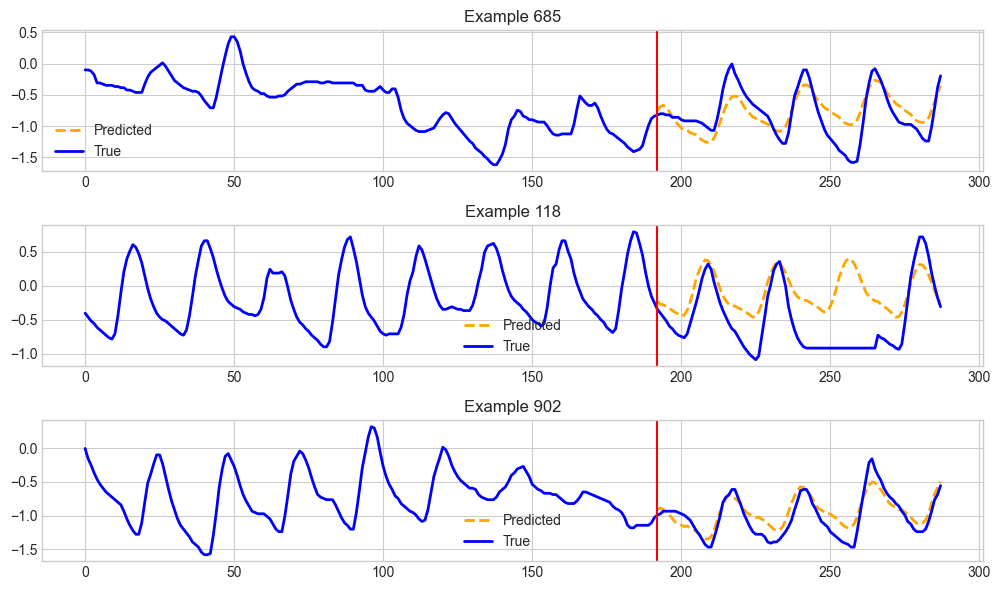

In [9]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=100,
    learning_rate=0.001,
    num_epochs=20,
)

# Analysis of TTM model on ETTh2 data

In [11]:
tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=CONTEXT_LENGTH,
    prediction_length=PREDICTION_LENGTH,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

dset_train, dset_val, dset_test = get_datasets(
        tsp,
        data,
        split_config,
        fewshot_fraction=1,
        fewshot_location="first",
        use_frequency_token=None,
    )
print("Length of train/val/test", len(dset_train), len(dset_val), len(dset_test))

print("Prediction channel indices derived from the preprocessor(TSP) methods - ", tsp.prediction_channel_indices)
print("Exogenous channel indices derived from the preprocessor(TSP) methods - ", tsp.exogenous_channel_indices)


Length of train/val/test 8033 2785 2785
Prediction channel indices derived from the preprocessor(TSP) methods -  [0]
Exogenous channel indices derived from the preprocessor(TSP) methods -  []


# Performance check on Validation set (Zero-shot and Finetuned model)

### Zero-shot 

In [12]:
# Load model
zeroshot_val_model = get_model(
    TTM_MODEL_PATH,
    context_length=CONTEXT_LENGTH,
    prediction_length=PREDICTION_LENGTH,
    freq_prefix_tuning=False,
    freq=None,
    prefer_l1_loss=False,
    prefer_longer_context=True,
    # adding TTM model config
    prediction_channel_indices=tsp.prediction_channel_indices,
    num_input_channels=tsp.num_input_channels,
)
temp_dir = tempfile.mkdtemp()

# zeroshot_trainer
zeroshot_val_trainer = Trainer(
    model=zeroshot_val_model,
    args=TrainingArguments(
        output_dir=temp_dir,
        per_device_eval_batch_size=BATCH_SIZE,
        seed=SEED,
        report_to="none",
    ),
)
# evaluate = zero-shot performance
print("+" * 20, "Val MSE zero-shot", "+" * 20)
zeroshot_val_output = zeroshot_val_trainer.evaluate(dset_val)
print("zeroshot performance on validation set", zeroshot_val_output)


INFO:p-94226:t-8466403200:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:p-94226:t-8466403200:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-94226:t-8466403200:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


++++++++++++++++++++ Val MSE zero-shot ++++++++++++++++++++


/opt/homebrew/Caskroom/miniforge/base/envs/ttm_env_new3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


zeroshot performance on validation set {'eval_loss': 0.1973312795162201, 'eval_model_preparation_time': 0.0012, 'eval_runtime': 0.7034, 'eval_samples_per_second': 3959.323, 'eval_steps_per_second': 62.553}


### Fine-tuned 

In [14]:
# loading the fine-tuned TTM model

fft_model = TinyTimeMixerForPrediction.from_pretrained("/Users/shivanitomar/Documents/Implementations/granite-tsfm/notebooks/hfdemo/ttm_finetuned_models/etth2/v1_fft/checkpoint-504")
temp_dir = tempfile.mkdtemp()

fft_trainer = Trainer(
        model=fft_model,
        args=TrainingArguments(
            output_dir=temp_dir,
            per_device_eval_batch_size=64,
            seed=SEED,
            report_to="none",
        ),
    )

print("+" * 20, "Val MSE fine-tuned", "+" * 20)
fft_val_output = fft_trainer.evaluate(dset_val)
print("fullshot finetuned performance on validation set", fft_val_output)


++++++++++++++++++++ Val MSE fine-tuned ++++++++++++++++++++


fullshot finetuned performance on validation set {'eval_loss': 0.17527730762958527, 'eval_model_preparation_time': 0.0011, 'eval_runtime': 0.6711, 'eval_samples_per_second': 4149.663, 'eval_steps_per_second': 65.56}


In [15]:
zs_val_preds = zeroshot_val_trainer.predict(dset_val)
fft_val_preds = fft_trainer.predict(dset_val)

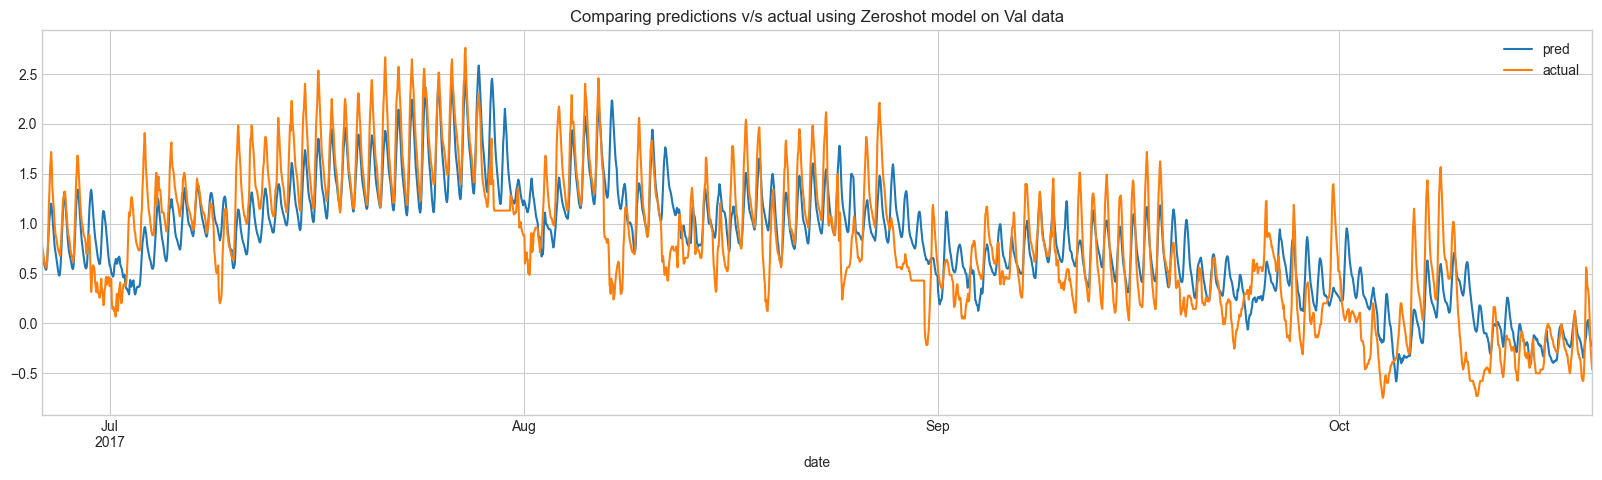

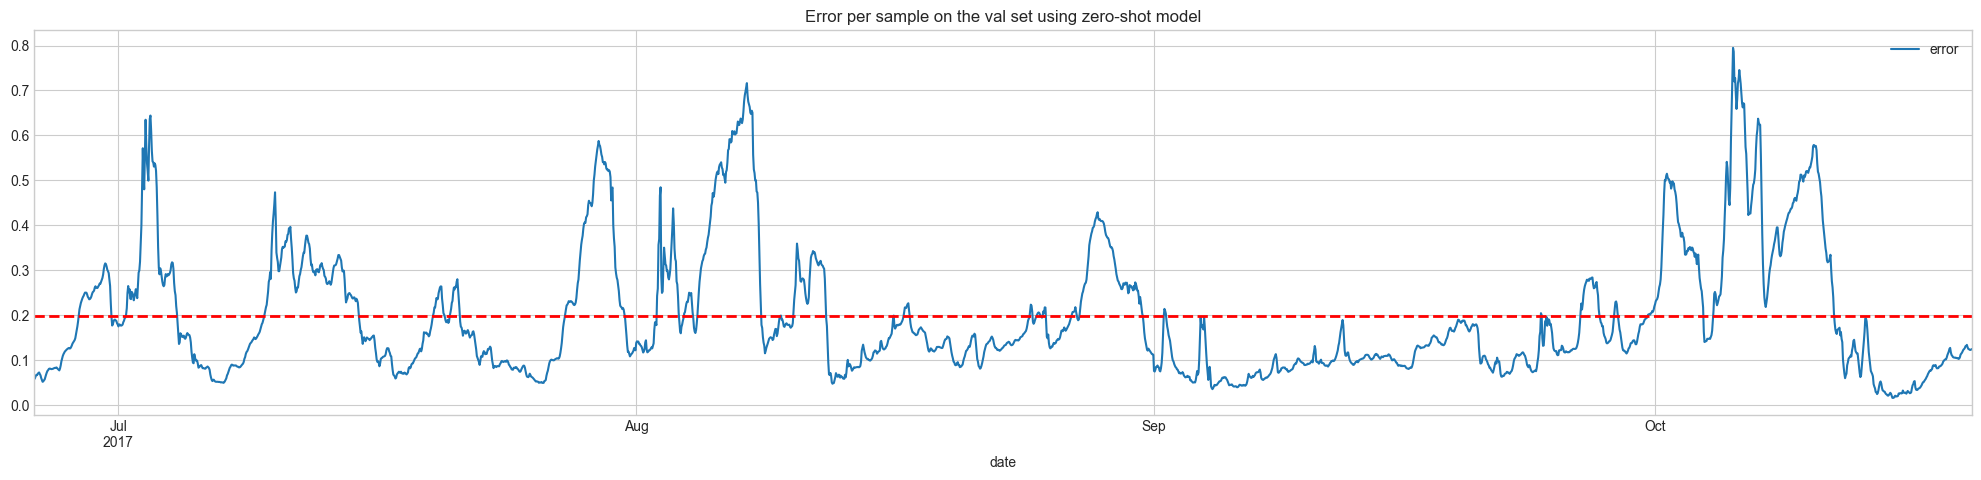

In [18]:
zs_val_df = construct_output_df(dset_val, zeroshot_val_trainer)
zs_out_predictions = compare_forecast(zs_val_df, "date", "prediction", "actual", 24)
zs_out_predictions.plot(x="date", y=["pred", "actual"], figsize=(20,5), title="Comparing predictions v/s actual using Zeroshot model on Val data")

zs_val_df["error"] = zs_val_df.apply(lambda row: mean_squared_error([row["prediction"]], [row["actual"]]), axis=1)
ax1 = zs_val_df.plot(x="date", y=["error"], figsize=(25, 5), title="Error per sample on the val set using zero-shot model")
ax1.axhline(y=zs_val_df['error'].mean(), color="red", linestyle="--", linewidth=2, label=f"Avg Error = {zs_val_df['error'].mean():.3f}")


In [20]:
high_error_val_samples = zs_val_df[zs_val_df["error"]>0.4]
high_error_val_samples

date                                         prediction  \
155  2017-07-02 10:00:00  [0.18521845, 0.2524316, 0.30320984, 0.3491958,...   
156  2017-07-02 11:00:00  [0.14879411, 0.20664877, 0.26008344, 0.2914344...   
157  2017-07-02 12:00:00  [0.24900502, 0.29907617, 0.3336334, 0.3359635,...   
158  2017-07-02 13:00:00  [0.32685873, 0.35376436, 0.35883942, 0.346255,...   
159  2017-07-02 14:00:00  [0.26670784, 0.27758527, 0.2742184, 0.26515839...   
...                  ...                                                ...   
2566 2017-10-10 21:00:00  [0.301427, 0.294118, 0.28842548, 0.27074194, 0...   
2567 2017-10-10 22:00:00  [0.21162006, 0.21929851, 0.21081305, 0.1932643...   
2568 2017-10-10 23:00:00  [0.16940734, 0.16804007, 0.1538842, 0.13401723...   
2569 2017-10-11 00:00:00  [0.097653866, 0.09220639, 0.07498865, 0.055546...   
2570 2017-10-11 01:00:00  [0.0063658357, 0.0015098155, -0.012983203, -0....   

                                                 actual  \
155   [0.0693998, 0.22115138, 0.29698402, 0.2021609,...   
156   [0.22115138, 0.29698402, 0.2021609, 0.12628494...   
157   [0.29698402, 0.2021609, 0.12628494, 0.24009871...   
158   [0.2021609, 0.12628494, 0.24009871, 0.3348787,...   
159   [0.12628494, 0.24009871, 0.3348787, 0.3728598,...   
...                                                 ...   
2566  [0.10733761, 0.050409153, -0.025466638, -0.120...   
2567  [0.050409153, -0.025466638, -0.120289765, -0.1...   
2568  [-0.025466638, -0.120289765, -0.1581846, -0.23...   
2569  [-0.120289765, -0.1581846, -0.23406039, -0.309...   
2570  [-0.1581846, -0.23406039, -0.3099362, -0.38581...   

                                                context  \
155   [0.35386935, 0.35386935, 0.35386935, 0.3728166...   
156   [0.35386935, 0.35386935, 0.37281668, 0.2590460...   
157   [0.35386935, 0.37281668, 0.25904605, 0.2400987...   
158   [0.37281668, 0.25904605, 0.24009871, 0.3918071...   
159   [0.25904605, 0.24009871, 0.39180717, 0.6004441...   
...                                                 ...   
2566  [0.80908096, 0.80908096, 0.71425784, 0.67632, ...   
2567  [0.80908096, 0.71425784, 0.67632, 0.52456844, ...   
2568  [0.71425784, 0.67632, 0.52456844, 0.39180717, ...   
2569  [0.67632, 0.52456844, 0.39180717, 0.35386935, ...   
2570  [0.52456844, 0.39180717, 0.35386935, 0.3728598...   

                                            full_window     error  
155   [0.35386935, 0.35386935, 0.35386935, 0.3728166...  0.486194  
156   [0.35386935, 0.35386935, 0.37281668, 0.2590460...  0.571432  
157   [0.35386935, 0.37281668, 0.25904605, 0.2400987...  0.508711  
158   [0.37281668, 0.25904605, 0.24009871, 0.3918071...  0.480067  
159   [0.25904605, 0.24009871, 0.39180717, 0.6004441...  0.563725  
...                                                 ...       ...  
2566  [0.80908096, 0.80908096, 0.71425784, 0.67632, ...  0.496034  
2567  [0.80908096, 0.71425784, 0.67632, 0.52456844, ...  0.477204  
2568  [0.71425784, 0.67632, 0.52456844, 0.39180717, ...  0.464075  
2569  [0.67632, 0.52456844, 0.39180717, 0.35386935, ...  0.437479  
2570  [0.52456844, 0.39180717, 0.35386935, 0.3728598...  0.410773  

[291 rows x 6 columns]

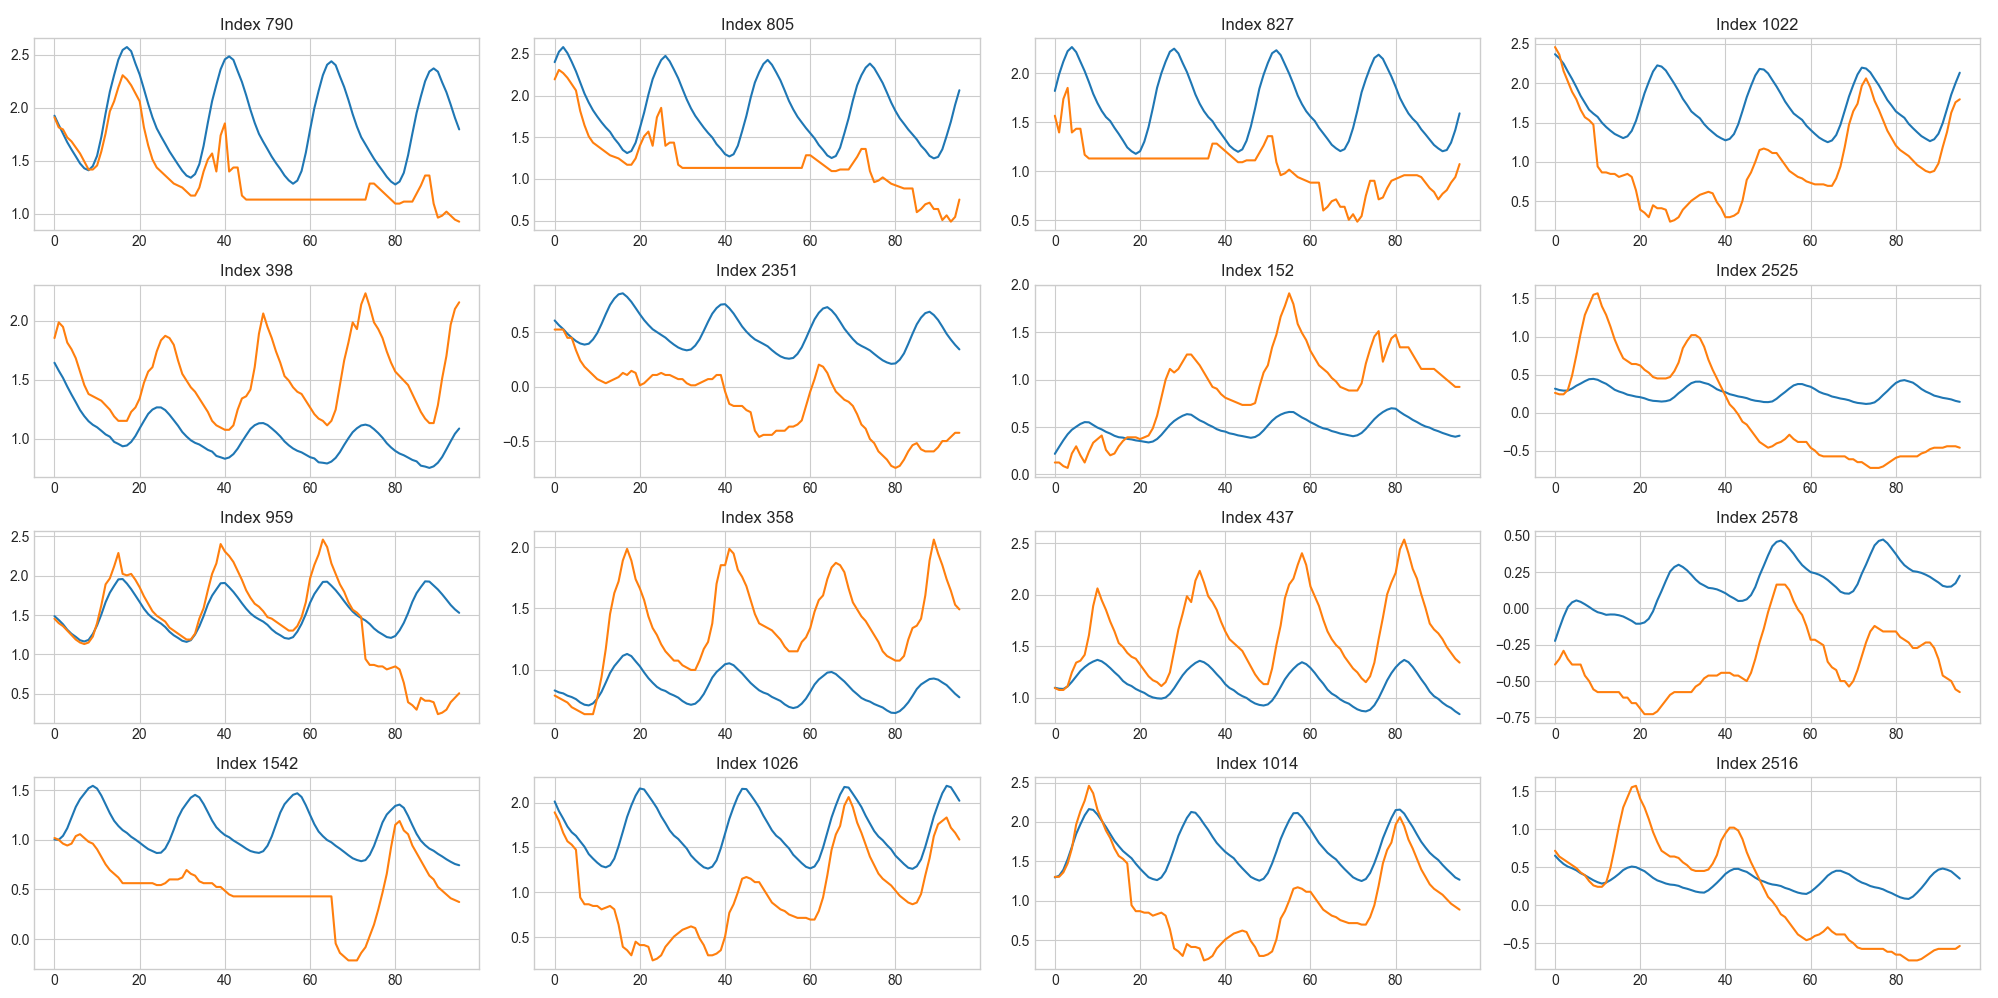

In [21]:
plot_high_error_samples(4, 4, zs_val_df, 0.3)


/opt/homebrew/Caskroom/miniforge/base/envs/ttm_env_new3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


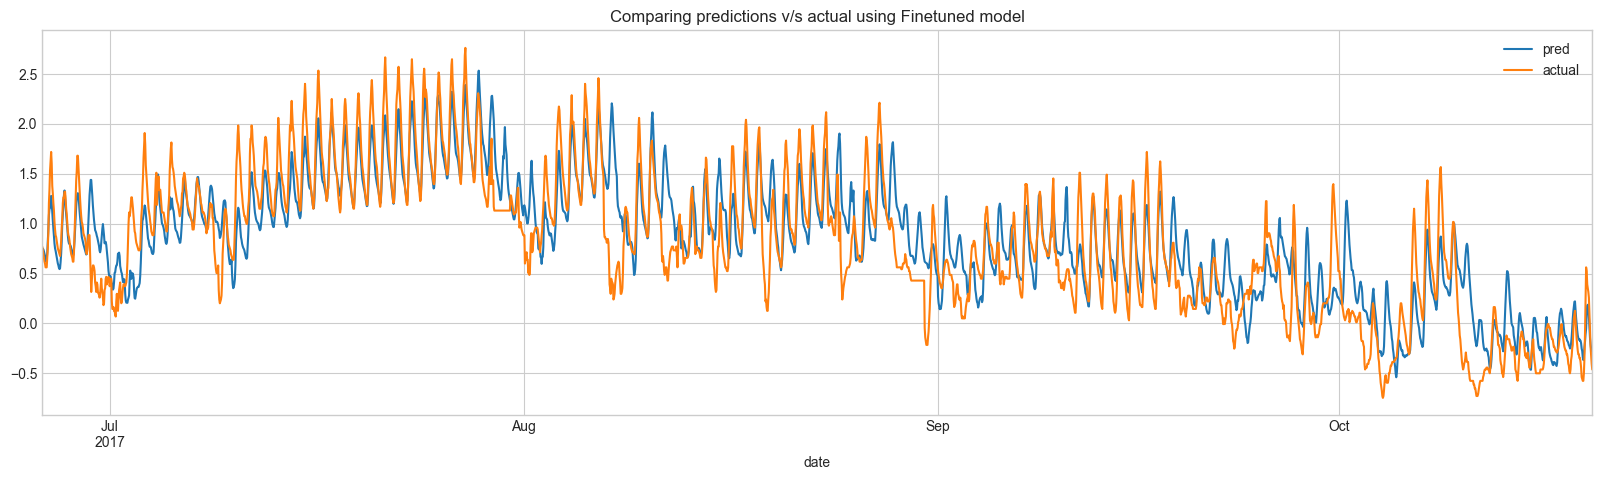

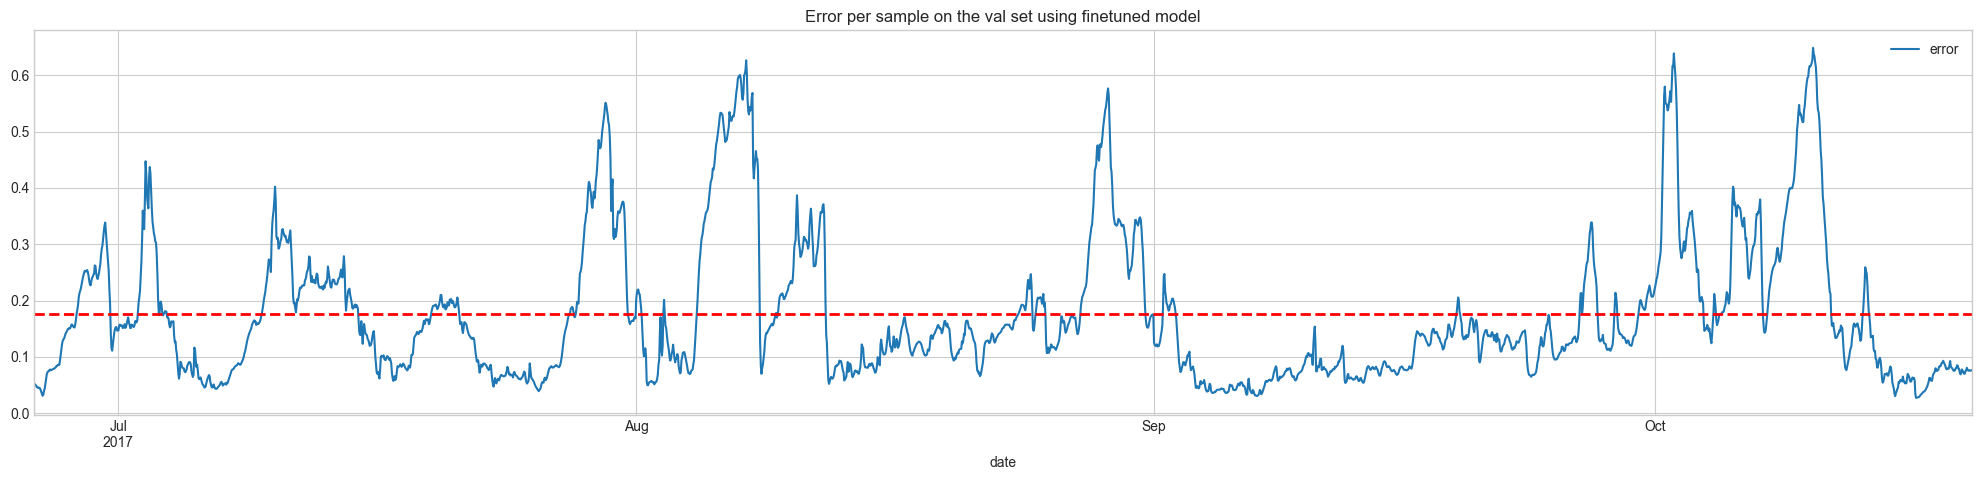

In [29]:
fft_val_df = construct_output_df(dset_val, fft_trainer)
ft_out_predictions = compare_forecast(fft_val_df, "date", "prediction", "actual", 24)
ft_out_predictions.plot(x="date", y=["pred", "actual"], figsize=(20,5), title="Comparing predictions v/s actual using Finetuned model")

fft_val_df["error"] = fft_val_df.apply(lambda row: mean_squared_error([row["prediction"]], [row["actual"]]), axis=1)
ax2 = fft_val_df.plot(x="date", y=["error"], figsize=(25, 5), title="Error per sample on the val set using finetuned model")
ax2.axhline(y=fft_val_df['error'].mean(), color="red", linestyle="--", linewidth=2, label=f"Avg Error = {fft_val_df['error'].mean():.3f}")

In [ ]:
plot_high_error_samples(4, 5, fft_val_df, 0.3)

# Performance check on Test set (Zero-shot and Finetuned model)

### Zeroshot

In [21]:
# Load model
zeroshot_test_model = get_model(
    TTM_MODEL_PATH,
    context_length=CONTEXT_LENGTH,
    prediction_length=PREDICTION_LENGTH,
    freq_prefix_tuning=False,
    freq=None,
    prefer_l1_loss=False,
    prefer_longer_context=True,
    # adding TTM model config
    prediction_channel_indices=tsp.prediction_channel_indices,
    num_input_channels=tsp.num_input_channels,
)
temp_dir = tempfile.mkdtemp()

# zeroshot_trainer
zeroshot_test_trainer = Trainer(
    model=zeroshot_test_model,
    args=TrainingArguments(
        output_dir=temp_dir,
        per_device_eval_batch_size=BATCH_SIZE,
        seed=SEED,
        report_to="none",
    ),
)
# evaluate = zero-shot performance
print("+" * 20, "Test MSE zero-shot", "+" * 20)
zeroshot_test_output = zeroshot_test_trainer.evaluate(dset_test)
print("zeroshot performance on test set", zeroshot_test_output)

INFO:p-41972:t-8466403200:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:p-41972:t-8466403200:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-41972:t-8466403200:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


/opt/homebrew/Caskroom/miniforge/base/envs/ttm_env_new3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


zeroshot performance on test set {'eval_loss': 0.05244337394833565, 'eval_model_preparation_time': 0.0012, 'eval_runtime': 0.762, 'eval_samples_per_second': 3654.631, 'eval_steps_per_second': 57.739}


/opt/homebrew/Caskroom/miniforge/base/envs/ttm_env_new3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


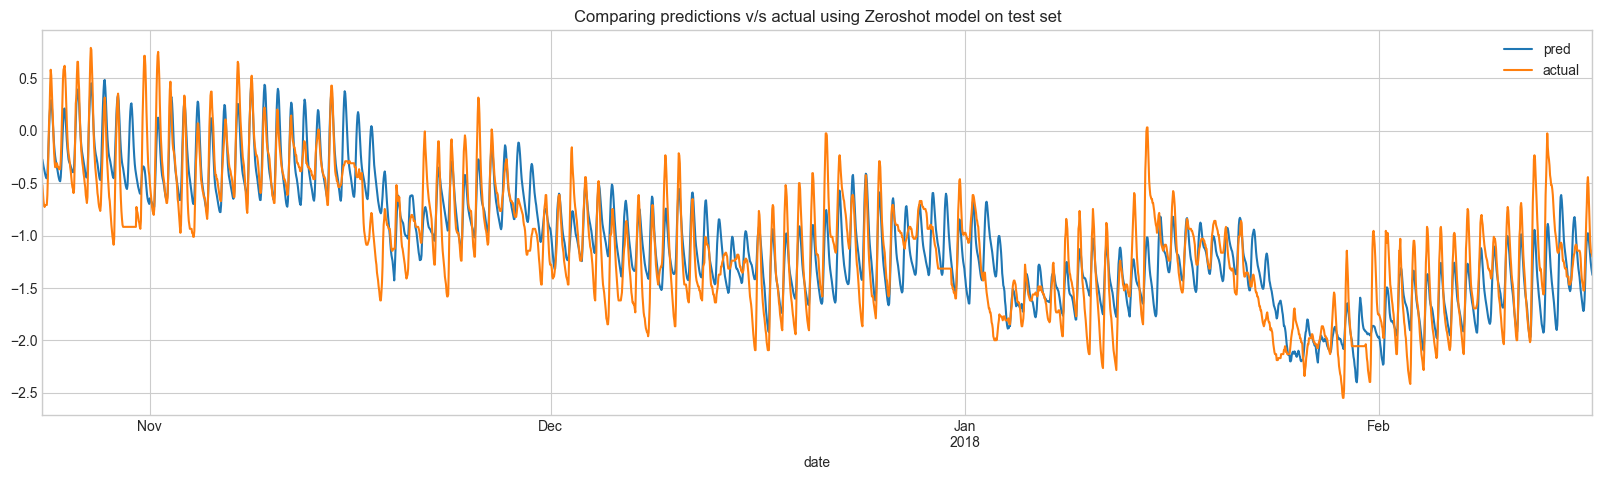

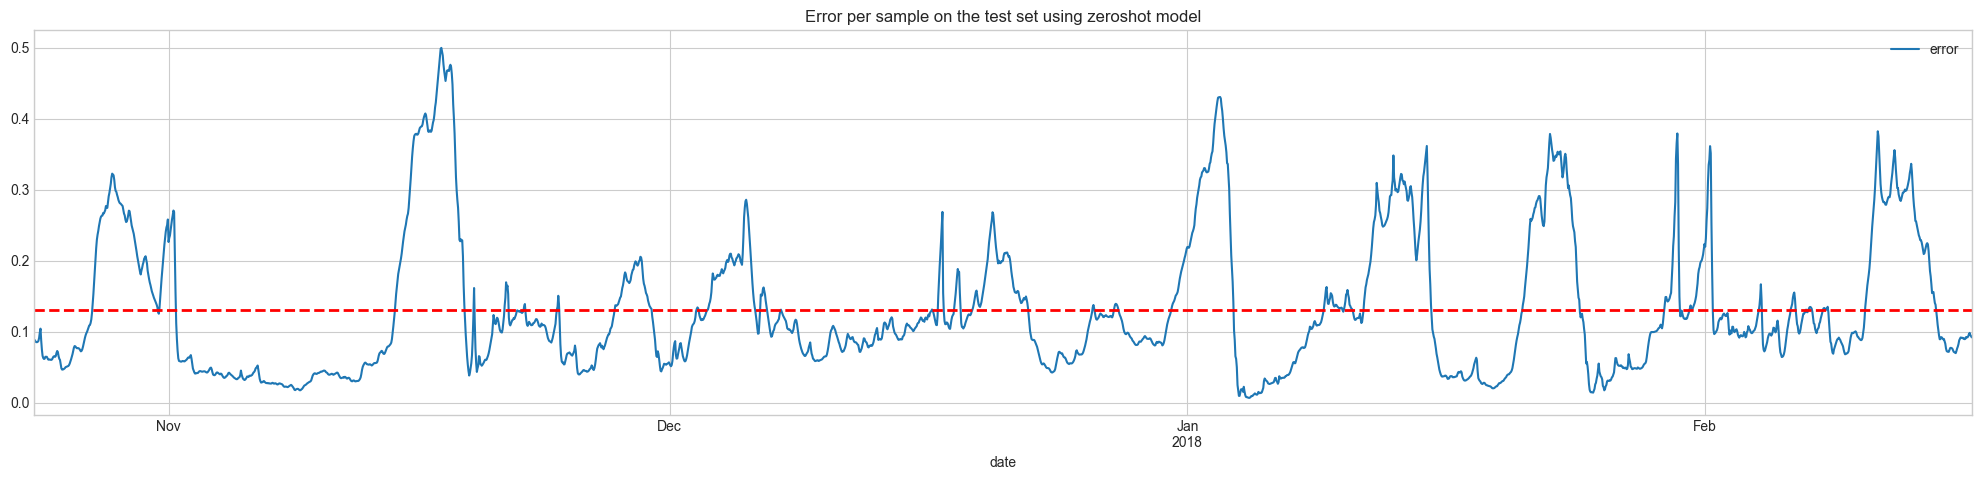

In [23]:
zs_test_df = construct_output_df(dset_test, zeroshot_val_trainer)
zs_test_predictions = compare_forecast(zs_test_df, "date", "prediction", "actual", 24)
zs_test_predictions.plot(x="date", y=["pred", "actual"], figsize=(20,5), title="Comparing predictions v/s actual using Zeroshot model on test set")

zs_test_df["error"] = zs_test_df.apply(lambda row: mean_squared_error([row["prediction"]], [row["actual"]]), axis=1)
ax3 = zs_test_df.plot(x="date", y=["error"], figsize=(25, 5), title="Error per sample on the test set using zeroshot model")
ax3.axhline(y=zs_test_df['error'].mean(), color="red", linestyle="--", linewidth=2, label=f"Avg Error = {zs_test_df['error'].mean():.3f}")

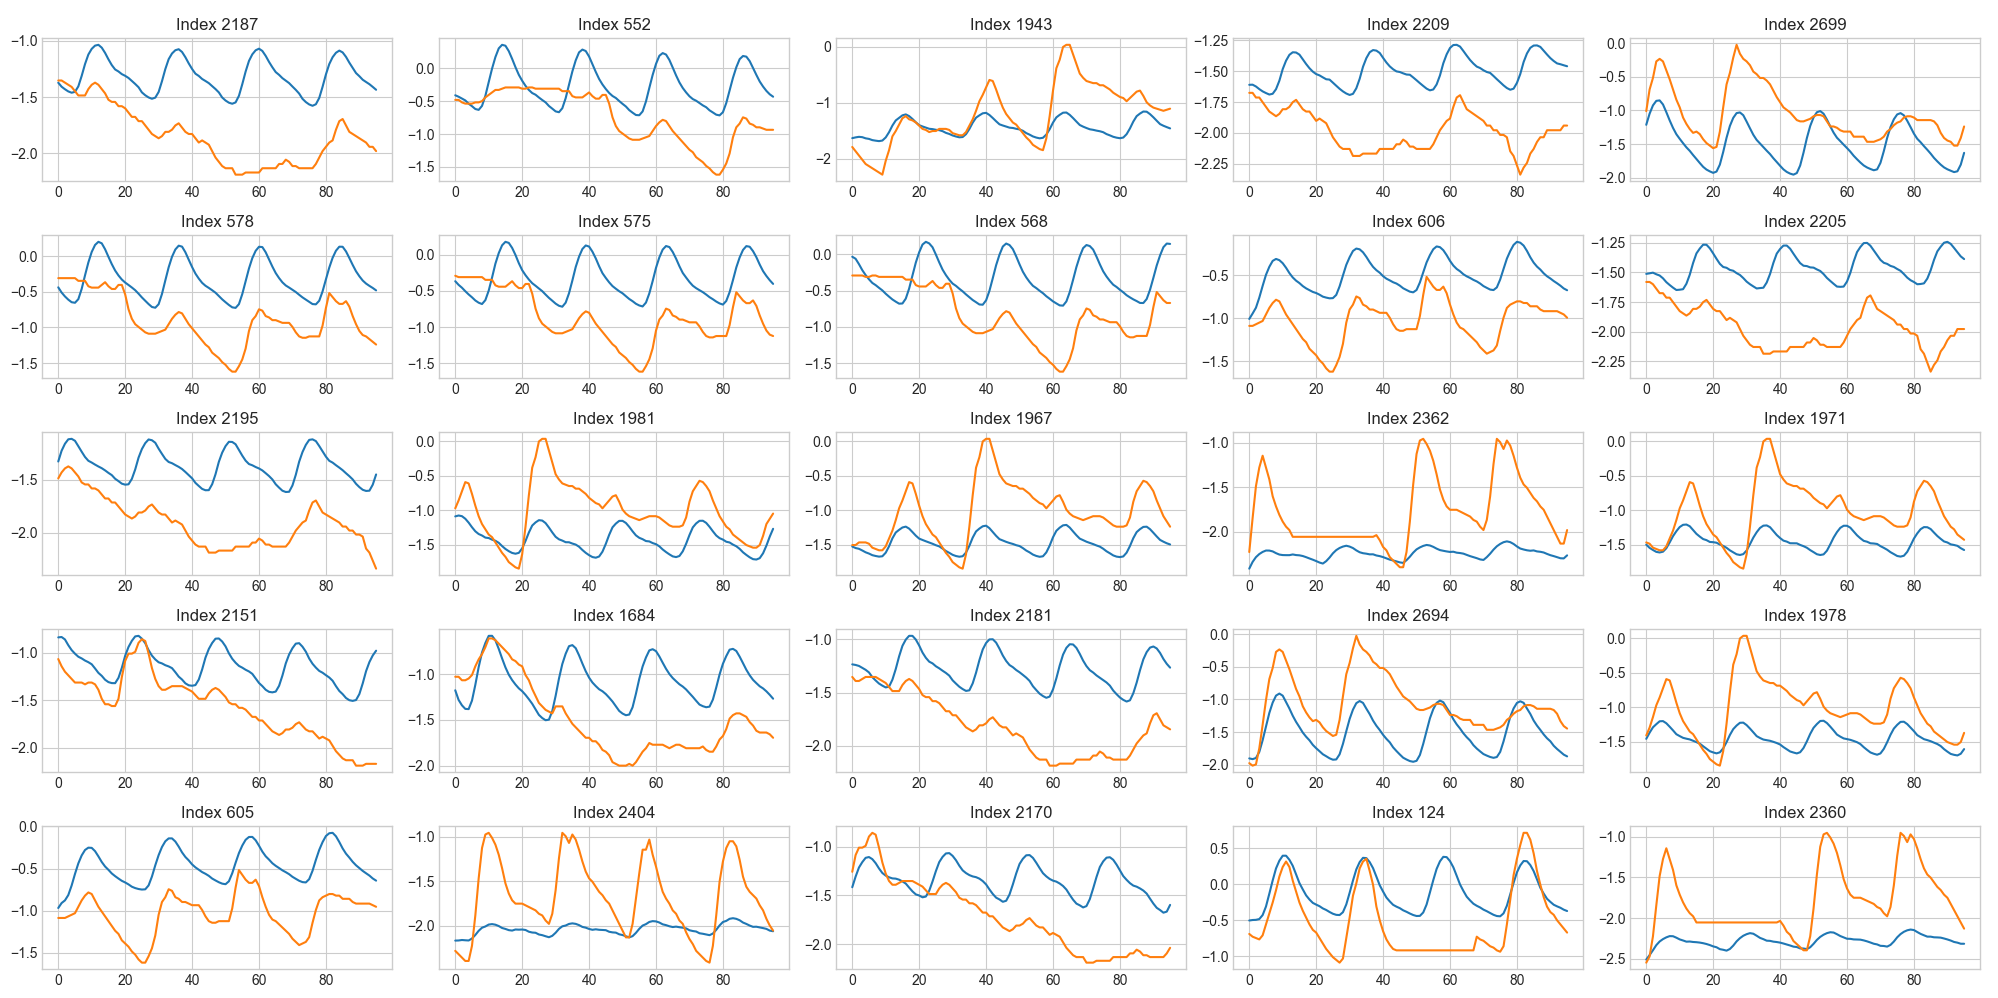

In [24]:
plot_high_error_samples(5, 5, zs_test_df, 0.25)

### Fine-Tuned

In [27]:
fine_tuned_model = TinyTimeMixerForPrediction.from_pretrained("/Users/shivanitomar/Documents/Implementations/granite-tsfm/notebooks/hfdemo/ttm_finetuned_models/etth2/v1_fft/checkpoint-504")
temp_dir = tempfile.mkdtemp()

fft_trainer = Trainer(
        model=fine_tuned_model,
        args=TrainingArguments(
            output_dir=temp_dir,
            per_device_eval_batch_size=64,
            seed=SEED,
            report_to="none",
        ),
    )

print("+" * 20, "Val MSE fine-tuned", "+" * 20)
fft_test_output = fft_trainer.evaluate(dset_test)
print("finetuned performance on test set", fft_test_output)

++++++++++++++++++++ Val MSE fine-tuned ++++++++++++++++++++


/opt/homebrew/Caskroom/miniforge/base/envs/ttm_env_new3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


finetuned performance on test set {'eval_loss': 0.12843233346939087, 'eval_model_preparation_time': 0.0012, 'eval_runtime': 0.6844, 'eval_samples_per_second': 4069.181, 'eval_steps_per_second': 64.289}


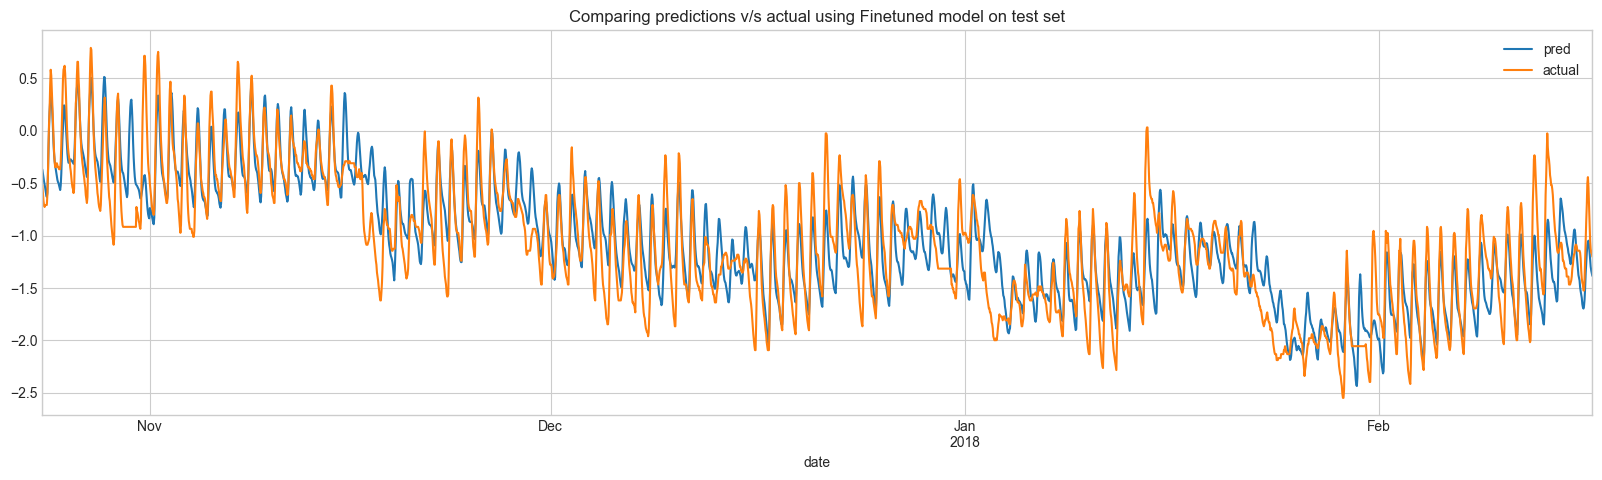

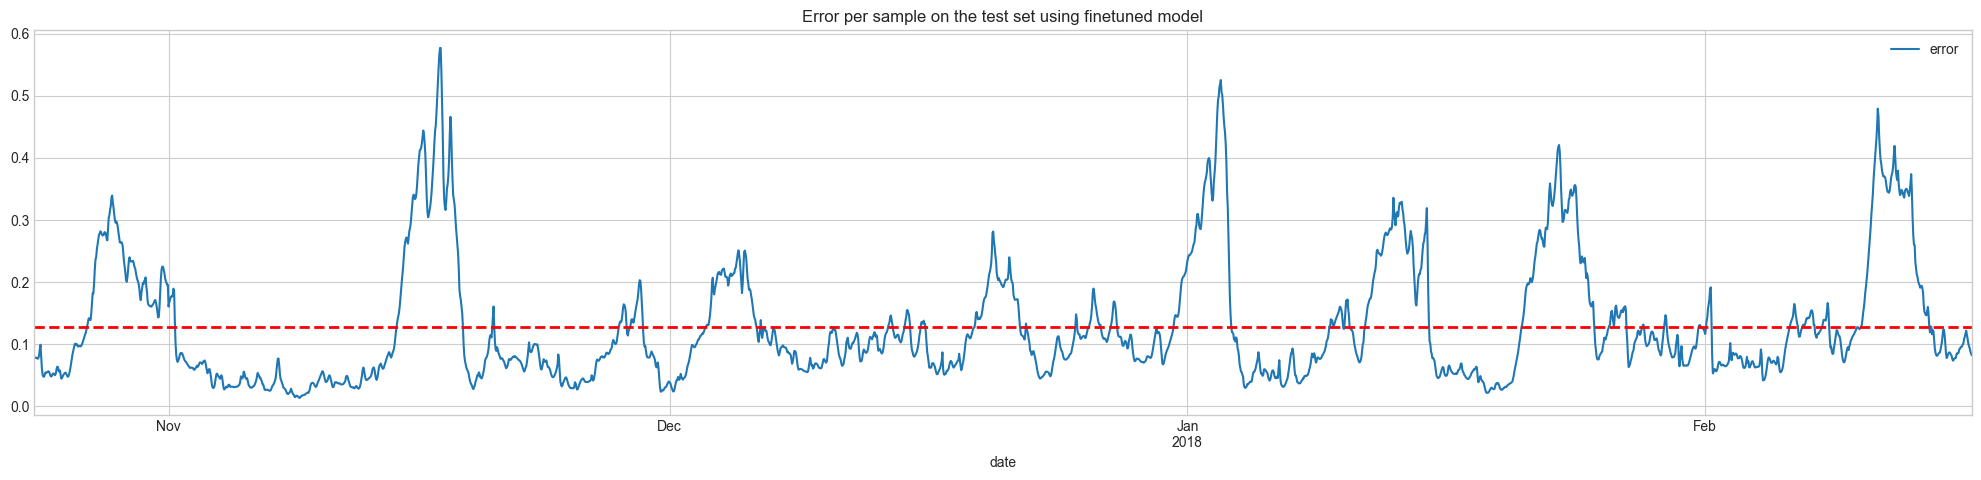

In [28]:
fft_test_df = construct_output_df(dset_test, fft_trainer)
ft_test_predictions = compare_forecast(fft_test_df, "date", "prediction", "actual", 24)
ft_test_predictions.plot(x="date", y=["pred", "actual"], figsize=(20,5), title="Comparing predictions v/s actual using Finetuned model on test set")

fft_test_df["error"] = fft_test_df.apply(lambda row: mean_squared_error([row["prediction"]], [row["actual"]]), axis=1)
ax3 = fft_test_df.plot(x="date", y=["error"], figsize=(25, 5), title="Error per sample on the test set using finetuned model")
ax3.axhline(y=fft_test_df['error'].mean(), color="red", linestyle="--", linewidth=2, label=f"Avg Error = {fft_test_df['error'].mean():.3f}")

In [ ]:
plot_high_error_samples(3, 5, fft_test_df, 0.2)

In [31]:
columns = ["ETTh2", "Validation", "Test"]
rows = [
    ["ZS", 0.1973, 0.0524],
    ["FT", 0.1752, 0.1284], 
]
res_df = pd.DataFrame(rows, columns=columns)
print(res_df)



  ETTh2  Validation    Test
0    ZS      0.1973  0.0524
1    FT      0.1752  0.1284


In [ ]:
# targeted training of model 

def targeted_finetune_eval(
    dataset_name,
    batch_size,
    learning_rate=None,
    context_length=512,
    forecast_length=96,
    fewshot_percent=100,
    freeze_backbone=True,
    num_epochs=10,
    save_dir=OUT_DIR,
    loss="mse",
    quantile=0.5,
):
    out_dir = os.path.join(save_dir, dataset_name)

    print("-" * 20, f"Running few-shot {fewshot_percent}%", "-" * 20)

    # Data prep: Get dataset
    

    # tsp = TimeSeriesPreprocessor(
    #     **column_specifiers,
    #     context_length=context_length,
    #     prediction_length=forecast_length,
    #     scaling=True,
    #     encode_categorical=False,
    #     scaler_type="standard",
    # )
    # print("+" * 20, "TSP values", "+" * 20)
    # print(tsp.prediction_channel_indices)
    # print(tsp.exogenous_channel_indices)
    # print(tsp.context_length)
    # print(tsp.prediction_length)
    # print(tsp.num_input_channels)
    # print(tsp.scaler_type)




    # change head dropout to 0.7 for ett datasets
    if "ett" in dataset_name:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            # Can also provide TTM Config args
            prediction_channel_indices=tsp.prediction_channel_indices,
            num_input_channels=tsp.num_input_channels,

            head_dropout=0.7,
            loss=loss,
            quantile=quantile,
        )
    else:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            # Can also provide TTM Config args
            loss=loss,
            quantile=quantile,
        )

    # dset_train, dset_val, dset_test = get_datasets(
    #     tsp,
    #     data,
    #     split_config,
    #     fewshot_fraction=fewshot_percent / 100,
    #     fewshot_location="first",
    #     use_frequency_token=finetune_forecast_model.config.resolution_prefix_tuning,
        
    # )
    # print("after get_datasets ------", len(dset_train))

    if freeze_backbone:
        print(
            "Number of params before freezing backbone",
            count_parameters(finetune_forecast_model),
        )

        # Freeze the backbone of the model
        for param in finetune_forecast_model.backbone.parameters():
            param.requires_grad = False

        # Count params
        print(
            "Number of params after freezing the backbone",
            count_parameters(finetune_forecast_model),
        )

    # Find optimal learning rate
    # Use with caution: Set it manually if the suggested learning rate is not suitable
    if learning_rate is None:
        learning_rate, finetune_forecast_model = optimal_lr_finder(
            finetune_forecast_model,
            dset_train,
            batch_size=batch_size,
        )
        print("OPTIMAL SUGGESTED LEARNING RATE =", learning_rate)

    print(f"Using learning rate = {learning_rate}")
    finetune_forecast_args = TrainingArguments(
        output_dir=os.path.join(out_dir, "v5_output"),
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        do_eval=True,
        eval_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=8,
        report_to="none",
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=1,
        logging_dir=os.path.join(out_dir, "logs"),  # Make sure to specify a logging directory
        load_best_model_at_end=True,  # Load the best model when training ends
        metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
        greater_is_better=False,  # For loss
        seed=SEED,
    )

    # Create the early stopping callback
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=5,  # Number of epochs with no improvement after which to stop
        early_stopping_threshold=1e-5,  # Minimum improvement required to consider as improvement
    )
    tracking_callback = TrackingCallback()

    # Optimizer and scheduler
    optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
    scheduler = OneCycleLR(
        optimizer,
        learning_rate,
        epochs=num_epochs,
        steps_per_epoch=math.ceil(len(dset_train_filtered) / (batch_size)),
    )
    print("length of training set is", len(dset_train_filtered))
    
    finetune_forecast_trainer = Trainer(
        model=finetune_forecast_model,
        args=finetune_forecast_args,
        train_dataset=dset_train_filtered,
        eval_dataset=dset_val,
        callbacks=[early_stopping_callback, tracking_callback],
        optimizers=(optimizer, scheduler),
    )
    finetune_forecast_trainer.remove_callback(INTEGRATION_TO_CALLBACK["codecarbon"])

    # Fine tune
    finetune_forecast_trainer.train()

    # Evaluation
    print("+" * 20, f"Test MSE after few-shot {fewshot_percent}% fine-tuning", "+" * 20)

    finetune_forecast_trainer.model.loss = "mse"  # fixing metric to mse for evaluation

    fewshot_output = finetune_forecast_trainer.evaluate(dset_test)
    print(fewshot_output)
    print("+" * 60)

    # get predictions

    predictions_dict = finetune_forecast_trainer.predict(dset_test)
    print("prediction metrics on test set", predictions_dict[2])

    predictions_np = predictions_dict.predictions[0]

    print(predictions_np.shape)

    # get backbone embeddings (if needed for further analysis)

    backbone_embedding = predictions_dict.predictions[1]

    print(backbone_embedding.shape)

    # plot
    plot_predictions(
        model=  .model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_fewshot",
        indices=[685, 118, 902],
        channel=0,
    )
    return predictions_dict

In [ ]:
targeted_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=100,
    learning_rate=0.001,
    num_epochs=20,
)

In [ ]:
targeted_ft_model = TinyTimeMixerForPrediction.from_pretrained("/Users/shivanitomar/Documents/Implementations/granite-tsfm/notebooks/hfdemo/ttm_finetuned_models/etth2/v5_output/checkpoint-65")
temp_dir = tempfile.mkdtemp()

targeted_ft_trainer = Trainer(
        model=targeted_ft_model,
        args=TrainingArguments(
            output_dir=temp_dir,
            per_device_eval_batch_size=64,
            seed=SEED,
            report_to="none",
        ),
    )

print("+" * 20, "Test MSE fine-tuned", "+" * 20)
targeted_ft_output = targeted_ft_trainer.evaluate(dset_test)
print("targeted finetuned performance on test set", targeted_ft_output)

In [ ]:
targeted_ft_test_df = construct_output_df(dset_test, targeted_ft_trainer)
tar_test_predictions = compare_forecast(targeted_ft_test_df, "date", "prediction", "actual", 24)
tar_test_predictions.plot(x="date", y=["pred", "actual"], figsize=(20,5), title="Comparing predictions v/s actual using targeted finetuned model on test set")

targeted_ft_test_df["error"] = targeted_ft_test_df.apply(lambda row: mean_squared_error([row["prediction"]], [row["actual"]]), axis=1)
ax4 = targeted_ft_test_df.plot(x="date", y=["error"], figsize=(25, 5), title="Error per sample on the test set using finetuned model")
ax4.axhline(y=targeted_ft_test_df['error'].mean(), color="red", linestyle="--", linewidth=2, label=f"Avg Error = {targeted_ft_test_df['error'].mean():.3f}")




In [ ]:
plot_high_error_samples(3, 5, targeted_ft_test_df, 0.2)

<Axes: title={'center': 'Error per sample on the test set using finetuned and targeted models'}, xlabel='date'>

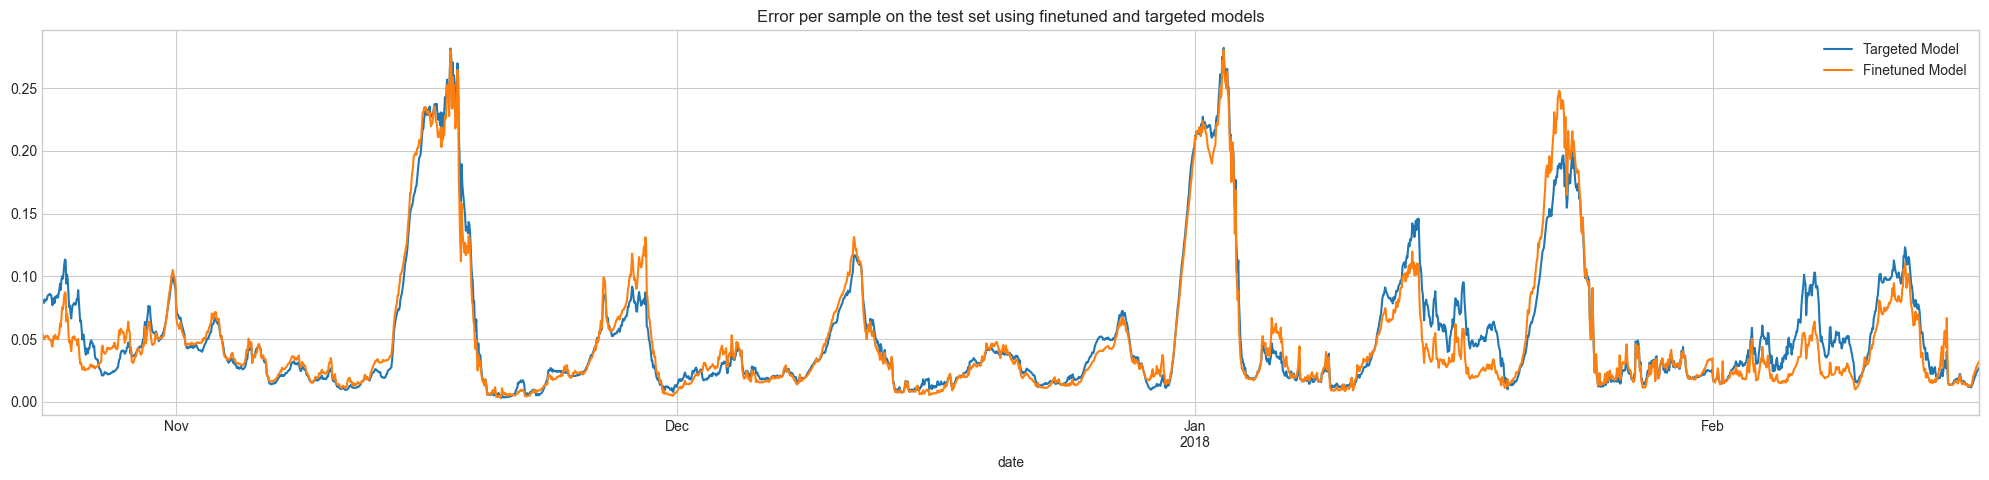

In [ ]:
ax5 = targeted_ft_test_df.plot(
    x="date",
    y="error",
    figsize=(25, 5),
    label="Targeted Model",
    title="Error per sample on the test set using finetuned and targeted models"
)


fft_test_df.plot(
    x="date",
    y="error",
    ax=ax4,         
    label="Finetuned Model"
)

### Learning shapelets from high error val samples

In [32]:
import sys
sys.path.append("/Users/shivanitomar/Documents/Implementations/ps_pgsm_shapelets/incremental_code")
import utils

In [34]:
context_array = np.array(high_error_val_samples["context"].tolist())
context_array.shape


(291, 512)

In [35]:
n, p = context_array.shape
r = 0.2
q = int(np.ceil(p * r))
k = 50
S, A, Offsets, F_obj = utils.USIDL_with_alpha_const(context_array, lambda_=0.1, K=k, q=q, c=100, epsilon=1e-5,
                                                    maxIter=2e3, maxInnerIter=5, random_seed=32)
shapelet_dict_v7 = {f'shapelet_{i}': S[i] for i in range(S.shape[0])}

# base_path = f"/Users/shivanitomar/Documents/Implementations/autotune_extension/learned_shapelets/{dataset}[0].pkl"
# with open(base_path, 'wb') as f:
#     pickle.dump(shapelet_dict, f)

# return shapelet_dict

setting random seed to 32 for dictionary initialization
Converged!


In [37]:
#rank shapelets based on alpha coeff 
alpha_df = pd.DataFrame(A)
k=25

alpha_sum = alpha_df.sum(axis=0).to_frame().T
topk_shap_idx = alpha_sum.iloc[0].nlargest(k).index
df_top25 = alpha_sum[topk_shap_idx]

select_shapelets_v7 = {}
for key, value in shapelet_dict_v7.items():
    idx = int(key.split("_")[1])
    if idx in topk_shap_idx:
        select_shapelets_v7[key] = value
    

In [40]:
df_top25

39         28         38         46         20         23  \
0  130.064357  72.200692  57.117452  54.412117  54.402583  52.155432   

          4          2          0          47  ...         17         1   \
0  51.038545  49.712934  49.333844  49.084561  ...  45.007255  44.294308   

          36         29         32        22         27         16         18  \
0  44.228736  43.791383  43.529326  43.40793  43.301921  42.890074  42.820546   

         26  
0  41.14583  

[1 rows x 25 columns]

In [41]:
def plot_shapelet_dict(shapelet_dict, cols):
    n_shapelets = len(shapelet_dict)
    rows = math.ceil(n_shapelets / cols)

    fig, axs = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
    axs = axs.flatten()

    for i, (shapelet_id, shapelet) in enumerate(shapelet_dict.items()):
        axs[i].plot(shapelet, color='blue')
        axs[i].set_title(f"{shapelet_id}")
        axs[i].set_xlabel("Time")
        axs[i].set_ylabel("Value")

    plt.tight_layout()
    plt.show()



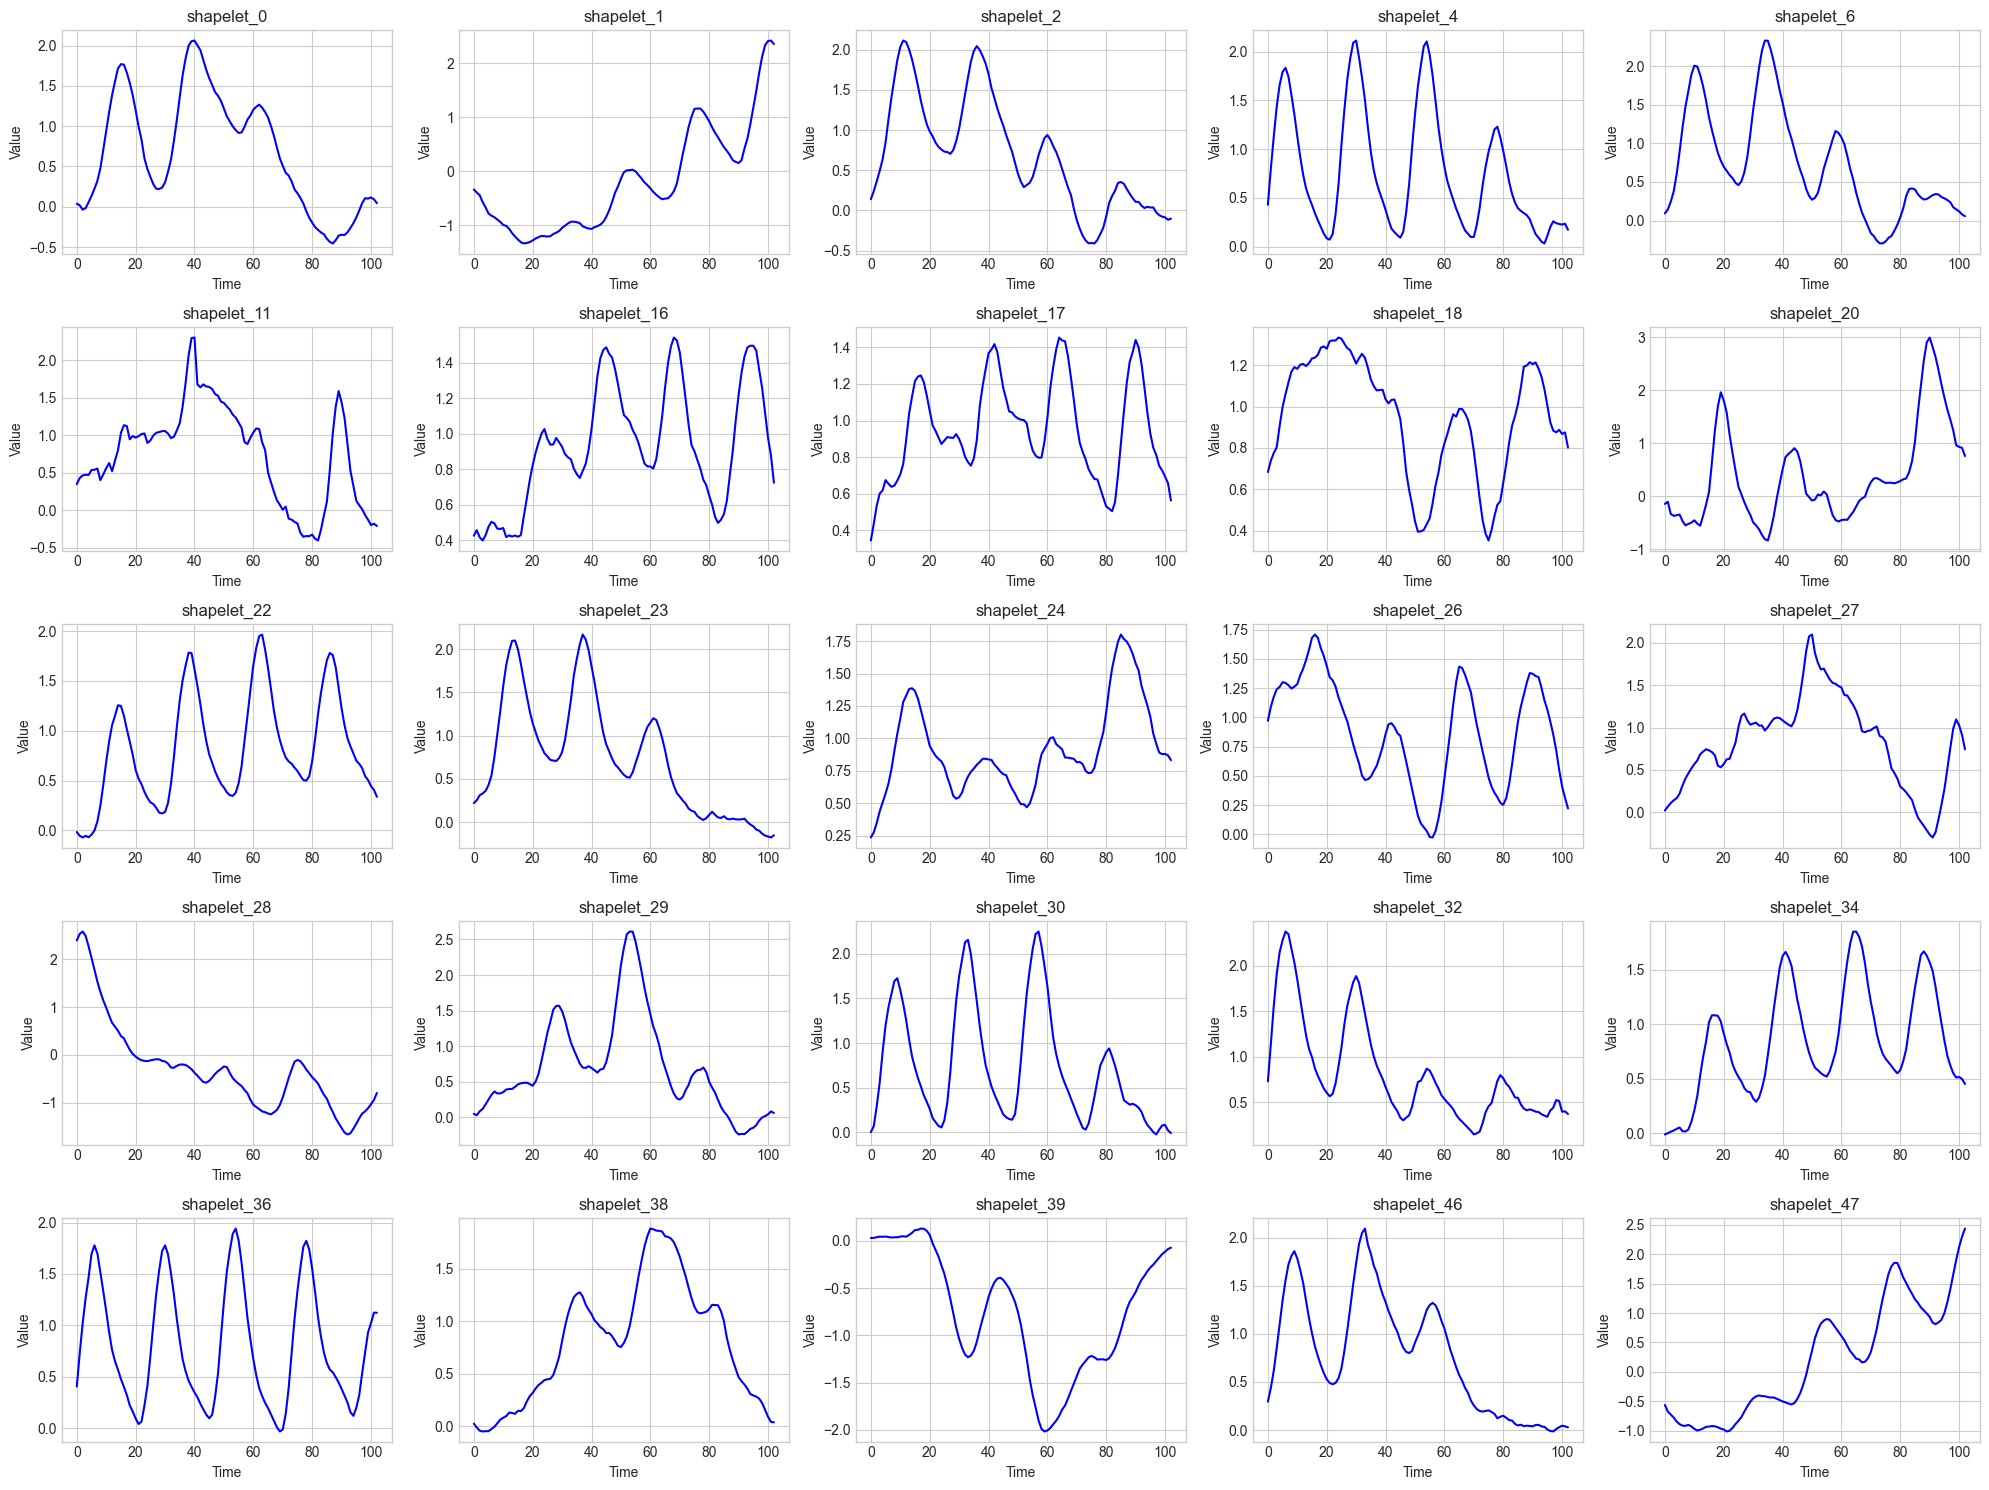

In [42]:
plot_shapelet_dict(select_shapelets_v7, 5)

In [45]:
import torch

# closest training samples to shapelets using ED learned from validation split 
def z_norm(x):
    return (x - np.mean(x)) / np.std(x)

def shapelet_distance(segment, series):
    seg = z_norm(segment)
    series = z_norm(series)
    seg_len = len(seg)
    return min(np.linalg.norm(seg - series[i:i+seg_len]) for i in range(len(series)-seg_len+1))

train_set = []
timestamps = []

for i in range(len(dset_train)):
    sample = dset_train[i]['past_values']
    train_set.append(sample)
    timestamps.append(dset_train[i]['timestamp']) 

train_context = torch.stack(train_set).squeeze(-1).numpy()
train_context_reshaped = np.expand_dims(train_context, axis=1)
columns = [f"timepoint_{i}" for i in range(train_context.shape[1])]
train_context_df = pd.DataFrame(train_context, columns=columns)
train_context_df["timestamp"] = timestamps
train_context_df.set_index("timestamp", inplace=True)

target_train_ed = np.zeros((len(dset_train),len(select_shapelets_v7)))

# save all the test distances with shapelets in an array
for i in range(len(train_context_df)):
    for j, shapelet in enumerate(select_shapelets_v7.values()):
        series = np.array(dset_train[i]["past_values"].squeeze(1))
        dist = shapelet_distance(shapelet, series)
        target_train_ed[i, j] = dist


In [47]:
target_train_ed.shape

(8033, 25)

In [48]:
from torch.utils.data import Subset

fraction = 0.1
targeted_samples = int(fraction * len(dset_train))

min_dists = target_train_ed.min(axis=1)
sorted_idx = np.argsort(min_dists)
selected_samples = sorted_idx[:targeted_samples]

dset_train_targeted = Subset(dset_train, selected_samples)


In [49]:
len(dset_train_targeted)

803

In [51]:
# targeted training of model 

def targeted_finetune_eval(
    dataset_name,
    batch_size,
    learning_rate=None,
    context_length=512,
    forecast_length=96,
    fewshot_percent=100,
    freeze_backbone=True,
    num_epochs=10,
    save_dir=OUT_DIR,
    loss="mse",
    quantile=0.5,
):
    out_dir = os.path.join(save_dir, dataset_name)

    print("-" * 20, f"Running few-shot {fewshot_percent}%", "-" * 20)

    # Data prep: Get dataset
    

    # tsp = TimeSeriesPreprocessor(
    #     **column_specifiers,
    #     context_length=context_length,
    #     prediction_length=forecast_length,
    #     scaling=True,
    #     encode_categorical=False,
    #     scaler_type="standard",
    # )
    # print("+" * 20, "TSP values", "+" * 20)
    # print(tsp.prediction_channel_indices)
    # print(tsp.exogenous_channel_indices)
    # print(tsp.context_length)
    # print(tsp.prediction_length)
    # print(tsp.num_input_channels)
    # print(tsp.scaler_type)




    # change head dropout to 0.7 for ett datasets
    if "ett" in dataset_name:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            # Can also provide TTM Config args
            prediction_channel_indices=tsp.prediction_channel_indices,
            num_input_channels=tsp.num_input_channels,

            head_dropout=0.8,
            loss=loss,
            quantile=quantile,
        )
    else:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            # Can also provide TTM Config args
            loss=loss,
            quantile=quantile,
        )

    # dset_train, dset_val, dset_test = get_datasets(
    #     tsp,
    #     data,
    #     split_config,
    #     fewshot_fraction=fewshot_percent / 100,
    #     fewshot_location="first",
    #     use_frequency_token=finetune_forecast_model.config.resolution_prefix_tuning,
        
    # )
    print("after get_datasets ------", len(dset_train_targeted))

    if freeze_backbone:
        print(
            "Number of params before freezing backbone",
            count_parameters(finetune_forecast_model),
        )

        # Freeze the backbone of the model
        for param in finetune_forecast_model.backbone.parameters():
            param.requires_grad = False

        # Count params
        print(
            "Number of params after freezing the backbone",
            count_parameters(finetune_forecast_model),
        )

    # Find optimal learning rate
    # Use with caution: Set it manually if the suggested learning rate is not suitable
    if learning_rate is None:
        learning_rate, finetune_forecast_model = optimal_lr_finder(
            finetune_forecast_model,
            dset_train,
            batch_size=batch_size,
        )
        print("OPTIMAL SUGGESTED LEARNING RATE =", learning_rate)

    print(f"Using learning rate = {learning_rate}")
    finetune_forecast_args = TrainingArguments(
        output_dir=os.path.join(out_dir, "v2_shap_LR0.001_DO0.8"),
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        do_eval=True,
        eval_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=8,
        report_to="none",
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=1,
        logging_dir=os.path.join(out_dir, "logs"),  # Make sure to specify a logging directory
        load_best_model_at_end=True,  # Load the best model when training ends
        metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
        greater_is_better=False,  # For loss
        seed=SEED,
    )

    # Create the early stopping callback
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=5,  # Number of epochs with no improvement after which to stop
        early_stopping_threshold=1e-5,  # Minimum improvement required to consider as improvement
    )
    tracking_callback = TrackingCallback()

    # Optimizer and scheduler
    optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
    scheduler = OneCycleLR(
        optimizer,
        learning_rate,
        epochs=num_epochs,
        steps_per_epoch=math.ceil(len(dset_train_targeted) / (batch_size)),
    )
    print("length of training set is", len(dset_train_targeted))
    
    finetune_forecast_trainer = Trainer(
        model=finetune_forecast_model,
        args=finetune_forecast_args,
        train_dataset=dset_train_targeted,
        eval_dataset=dset_val,
        callbacks=[early_stopping_callback, tracking_callback],
        optimizers=(optimizer, scheduler),
    )
    finetune_forecast_trainer.remove_callback(INTEGRATION_TO_CALLBACK["codecarbon"])

    # Fine tune
    finetune_forecast_trainer.train()

    # Evaluation
    print("+" * 20, f"Test MSE after few-shot {fewshot_percent}% fine-tuning", "+" * 20)

    finetune_forecast_trainer.model.loss = "mse"  # fixing metric to mse for evaluation

    fewshot_output = finetune_forecast_trainer.evaluate(dset_test)
    print(fewshot_output)
    print("+" * 60)

    # get predictions

    predictions_dict = finetune_forecast_trainer.predict(dset_test)
    print("prediction metrics on test set", predictions_dict[2])

    predictions_np = predictions_dict.predictions[0]

    print(predictions_np.shape)

    # get backbone embeddings (if needed for further analysis)

    backbone_embedding = predictions_dict.predictions[1]

    print(backbone_embedding.shape)

    # plot
    plot_predictions(
        model=finetune_forecast_trainer.model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_fewshot",
        indices=[685, 118, 902],
        channel=0,
    )
    return predictions_dict

INFO:p-94226:t-8466403200:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


-------------------- Running few-shot 100% --------------------


INFO:p-94226:t-8466403200:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-94226:t-8466403200:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


after get_datasets ------ 803
Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696
Using learning rate = 0.001
length of training set is 803


/opt/homebrew/Caskroom/miniforge/base/envs/ttm_env_new3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


/opt/homebrew/Caskroom/miniforge/base/envs/ttm_env_new3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/Caskroom/miniforge/base/envs/ttm_env_new3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/Caskroom/miniforge/base/envs/ttm_env_new3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/Caskroom/miniforge/base/envs/ttm_env_new3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not suppo

[TrackingCallback] Mean Epoch Time = 58.87473985552788 seconds, Total Train Time = 945.2996158599854
++++++++++++++++++++ Test MSE after few-shot 100% fine-tuning ++++++++++++++++++++


/opt/homebrew/Caskroom/miniforge/base/envs/ttm_env_new3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.13021816313266754, 'eval_runtime': 59.0585, 'eval_samples_per_second': 47.157, 'eval_steps_per_second': 0.745, 'epoch': 8.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
prediction metrics on test set {'test_loss': 0.13021816313266754, 'test_runtime': 59.1897, 'test_samples_per_second': 47.052, 'test_steps_per_second': 0.743}
(2785, 96, 1)
(2785, 1, 8, 192)


PredictionOutput(predictions=(array([[[-0.4237164 ],
        [-0.39296907],
        [-0.38502583],
        ...,
        [-0.20838642],
        [-0.26051354],
        [-0.28148413]],

       [[-0.45813143],
        [-0.42197514],
        [-0.41372657],
        ...,
        [-0.2539842 ],
        [-0.2953339 ],
        [-0.307481  ]],

       [[-0.4840998 ],
        [-0.44966313],
        [-0.4432484 ],
        ...,
        [-0.279586  ],
        [-0.3184258 ],
        [-0.33438998]],

       ...,

       [[-1.2470295 ],
        [-1.3075246 ],
        [-1.3592649 ],
        ...,
        [-1.250577  ],
        [-1.3298854 ],
        [-1.3839461 ]],

       [[-1.2651752 ],
        [-1.3271946 ],
        [-1.390947  ],
        ...,
        [-1.3070548 ],
        [-1.3713772 ],
        [-1.415268  ]],

       [[-1.2752423 ],
        [-1.3495783 ],
        [-1.4215211 ],
        ...,
        [-1.3484873 ],
        [-1.4001502 ],
        [-1.4339234 ]]], dtype=float32), array([[[[ 7.08209118e-

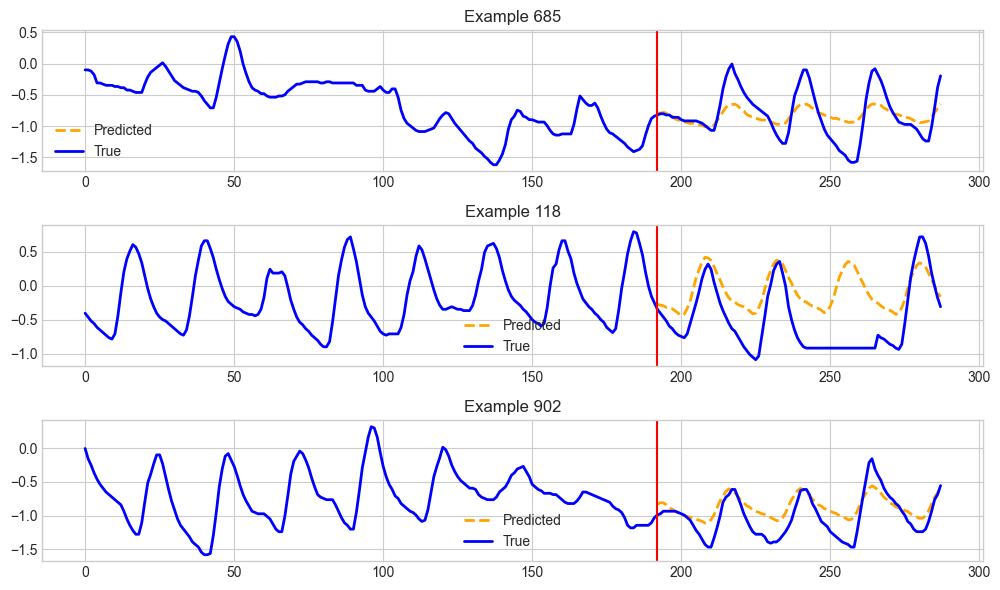

In [52]:
targeted_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=100,
    learning_rate=0.001,
    num_epochs=20,
)

In [54]:
targeted_shap_model = TinyTimeMixerForPrediction.from_pretrained("/Users/shivanitomar/Documents/Implementations/granite-tsfm/notebooks/hfdemo/ttm_finetuned_models/etth2/v2_shap_LR0.001_DO0.8/checkpoint-39")
temp_dir = tempfile.mkdtemp()

targeted_shap_trainer = Trainer(
        model=targeted_shap_model,
        args=TrainingArguments(
            output_dir=temp_dir,
            per_device_eval_batch_size=64,
            seed=SEED,
            report_to="none",
        ),
    )

print("+" * 20, "Test MSE fine-tuned", "+" * 20)
targeted_output = targeted_shap_trainer.evaluate(dset_test)
print("targeted shap performance on test set", targeted_output)

++++++++++++++++++++ Test MSE fine-tuned ++++++++++++++++++++


/opt/homebrew/Caskroom/miniforge/base/envs/ttm_env_new3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


targeted shap performance on test set {'eval_loss': 0.13021816313266754, 'eval_model_preparation_time': 0.0011, 'eval_runtime': 0.6628, 'eval_samples_per_second': 4201.889, 'eval_steps_per_second': 66.385}


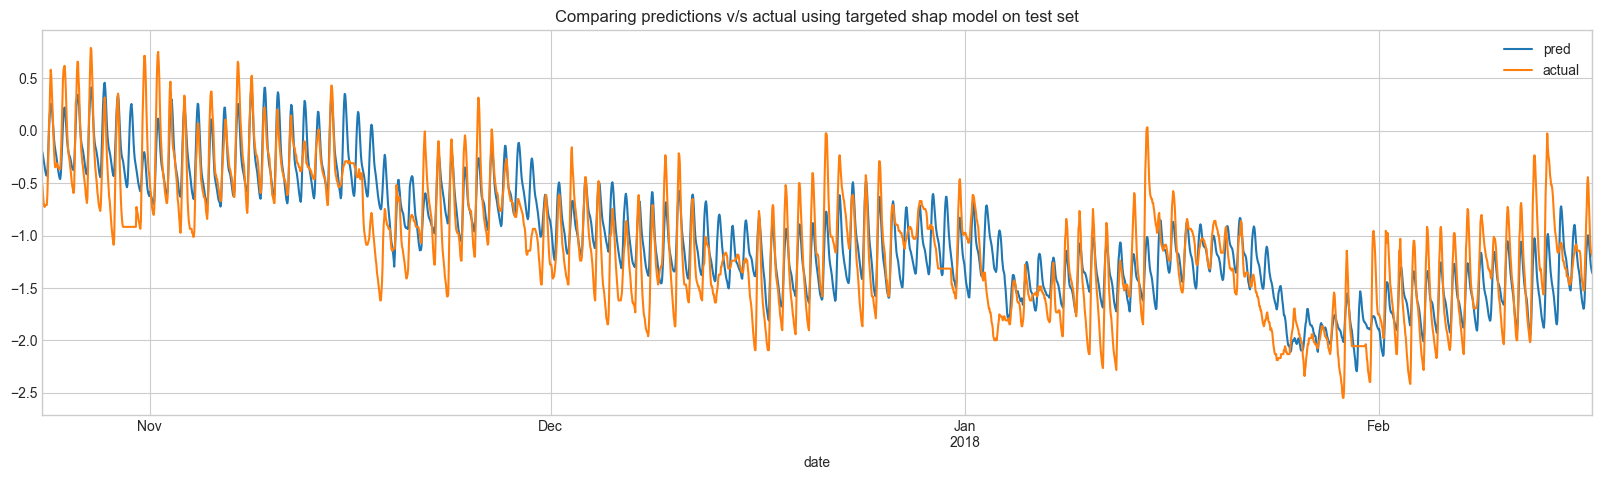

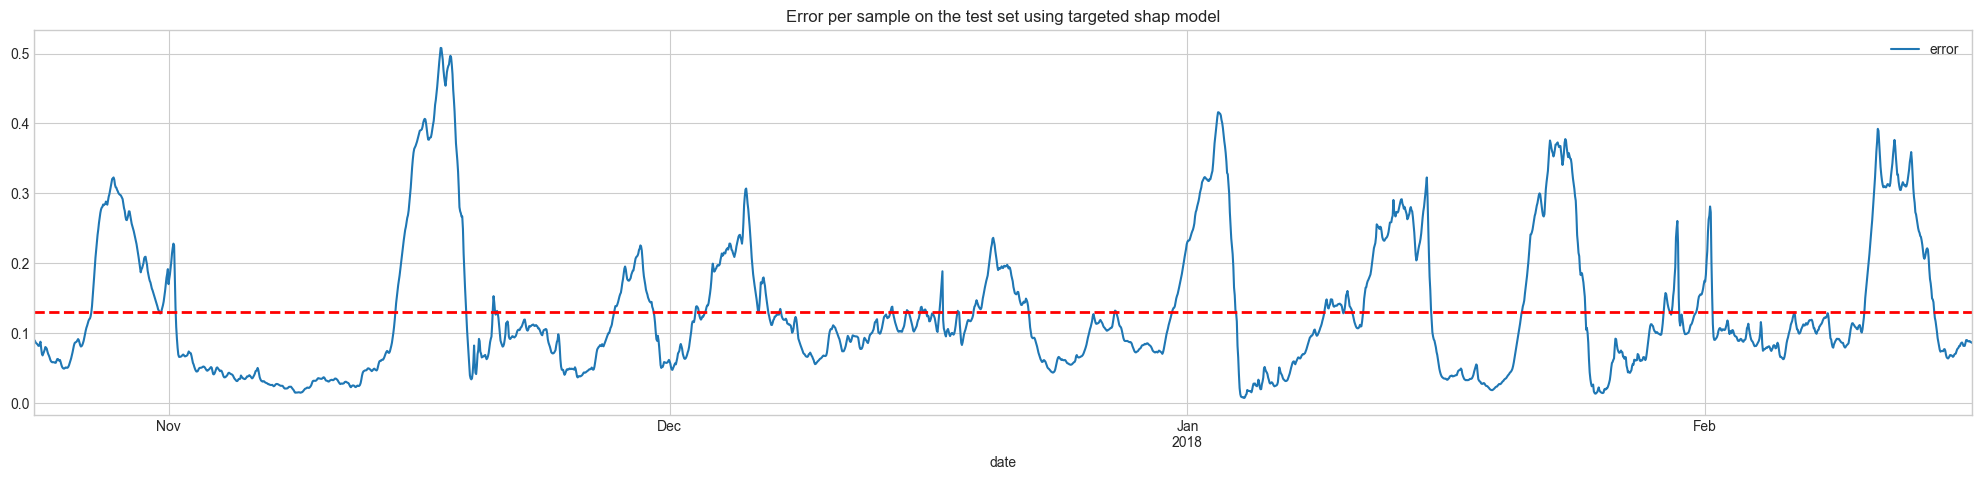

In [55]:
targeted_shap_df = construct_output_df(dset_test, targeted_shap_trainer)
tar_shap_predictions = compare_forecast(targeted_shap_df, "date", "prediction", "actual", 24)
tar_shap_predictions.plot(x="date", y=["pred", "actual"], figsize=(20,5), title="Comparing predictions v/s actual using targeted shap model on test set")

targeted_shap_df["error"] = targeted_shap_df.apply(lambda row: mean_squared_error([row["prediction"]], [row["actual"]]), axis=1)
ax6 = targeted_shap_df.plot(x="date", y=["error"], figsize=(25, 5), title="Error per sample on the test set using targeted shap model")
ax6.axhline(y=targeted_shap_df['error'].mean(), color="red", linestyle="--", linewidth=2, label=f"Avg Error = {targeted_shap_df['error'].mean():.3f}")

<Axes: title={'center': 'Error per sample on the test set using finetuned and targeted(shap) models'}, xlabel='date'>

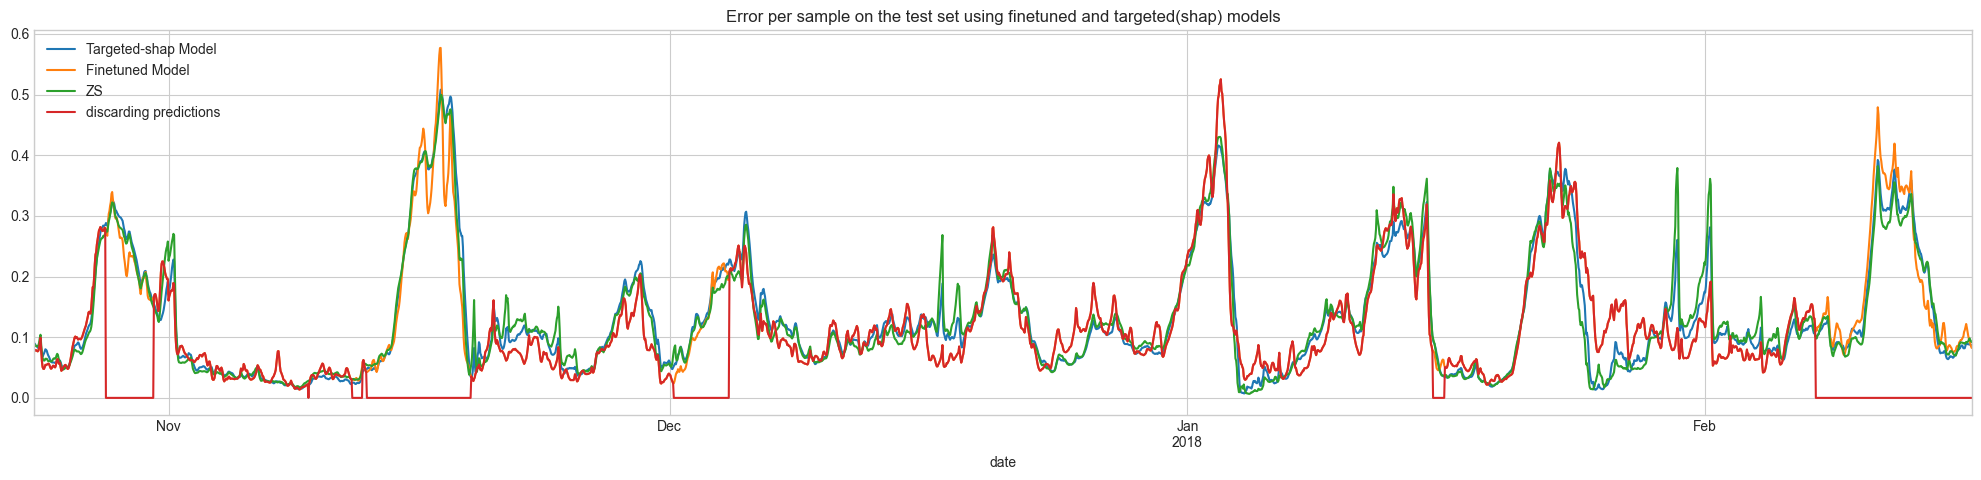

In [66]:
ax8 = targeted_shap_df.plot(
    x="date",
    y="error",
    figsize=(25, 5),
    label="Targeted-shap Model",
    title="Error per sample on the test set using finetuned and targeted(shap) models"
)


fft_test_df.plot(
    x="date",
    y="error",
    ax=ax8,         
    label="Finetuned Model"
)

zs_test_df.plot(
    x="date",
    y="error",
    ax=ax8,
    label="ZS"
)

discard_df.plot(
    x="date",
    y="error",
    ax=ax8,
    label="discarding predictions"




)


### Next Steps 
- Check similarity with test samples and discard samples based on average similarity on validation set.
- Cross check if the predictions for discarded test samples were greater than average zero shot error.

In [56]:
drop_limit = int(0.2 * len(dset_test))
print("Allowed number of samples to discard predictions", drop_limit)

Allowed number of samples to discard predictions 557


### Using FastDTW metric

In [ ]:
# Comparing shapelets to test set samples based on distance similarity to discard predictions 

test_distances = np.zeros((len(dset_test),len(shapelet_dict_v3)))

# save all the test distances with shapelets in an array
for i in range(len(dset_test)):
    for j, shapelet in enumerate(shapelet_dict_v3.values()):
        dist = fastdtw(dset_test[i]["past_values"], shapelet)[0]
        test_distances[i, j] = dist      


Allowed number of samples to discard predictions 278


### Using Euclidean Distance metric

In [57]:
len(select_shapelets_v7)

25

In [58]:
def z_norm(x):
    return (x - np.mean(x)) / np.std(x)

def shapelet_distance(segment, series):
    seg = z_norm(segment)
    series = z_norm(series)
    seg_len = len(seg)
    return min(np.linalg.norm(seg - series[i:i+seg_len]) for i in range(len(series)-seg_len+1))


test_distances_ed = np.zeros((len(dset_test),len(select_shapelets_v7)))

# save all the test distances with shapelets in an array
for i in range(len(dset_test)):
    for j, shapelet in enumerate(select_shapelets_v7.values()):
        series = np.array(dset_test[i]["past_values"].squeeze(1))
        dist = shapelet_distance(shapelet, series)
        test_distances_ed[i, j] = dist

In [59]:
pd.DataFrame(test_distances_ed)

0         1         2         3         4         5         6   \
0     9.228215  4.249913  7.861199  6.705768  8.957099  9.612557  6.981034   
1     9.211489  4.260188  7.860906  6.697367  8.954729  9.601494  6.971096   
2     9.193241  4.271834  7.860890  6.688344  8.952404  9.589481  6.960375   
3     9.174107  4.282300  7.857865  6.678773  8.947079  9.576720  6.948996   
4     9.156447  4.288439  7.849385  6.669608  8.936729  9.564588  6.938129   
...        ...       ...       ...       ...       ...       ...       ...   
2780  9.663091  8.200983  8.133152  6.645225  7.398251  8.583803  6.323349   
2781  9.670038  8.212301  8.142195  6.651184  7.408173  8.591833  6.335429   
2782  9.676712  8.223295  8.150962  6.657062  7.417833  8.599607  6.347240   
2783  9.681681  8.232328  8.157971  6.661992  7.425764  8.605721  6.357251   
2784  9.685473  8.239911  8.163713  6.666213  7.432420  8.610653  6.365883   

            7         8         9   ...        15        16        17  \
0     6.171746  9.312155  6.041153  ...  7.319767  9.739696  7.076781   
1     6.160465  9.300884  6.034437  ...  7.301803  9.722377  7.066389   
2     6.148281  9.288645  6.027294  ...  7.282254  9.703480  7.055170   
3     6.135570  9.275714  6.019612  ...  7.261126  9.683474  7.043193   
4     6.123839  9.263547  6.012003  ...  7.240451  9.664662  7.031649   
...        ...       ...       ...  ...       ...       ...       ...   
2780  4.959110  8.660018  6.991579  ...  9.658362  8.721217  6.555305   
2781  4.974624  8.644589  6.985862  ...  9.660428  8.732253  6.563844   
2782  4.989853  8.629522  6.980359  ...  9.662372  8.742920  6.572231   
2783  5.003148  8.615853  6.975359  ...  9.663329  8.751426  6.579359   
2784  5.014888  8.603436  6.970820  ...  9.663662  8.758374  6.585520   

            18        19        20        21         22        23        24  
0     7.395770  6.195867  4.121203  9.458895   5.751278  9.163170  5.891279  
1     7.394084  6.184379  4.111369  9.444354   5.740290  9.147721  5.895249  
2     7.392551  6.171968  4.100853  9.428511   5.746206  9.130879  5.899887  
3     7.387977  6.159003  4.090597  9.411906   5.915258  9.113276  5.903535  
4     7.378139  6.147016  4.082320  9.396576   6.202263  9.097117  5.904438  
...        ...       ...       ...       ...        ...       ...       ...  
2780  8.128978  5.200500  3.801449  8.052956  10.134665  8.826132  8.607689  
2781  8.134496  5.205775  3.810079  8.068503  10.138472  8.832829  8.618841  
2782  8.139861  5.211100  3.818803  8.083572  10.142103  8.839303  8.629650  
2783  8.144037  5.215953  3.827065  8.095973  10.144515  8.844280  8.638428  
2784  8.147376  5.220392  3.834823  8.106394  10.146122  8.848207  8.645720  

[2785 rows x 25 columns]

In [62]:
import warnings

min_dists = test_distances_ed.min(axis=1)
sorted_idx = np.argsort(min_dists)
samples_to_drop = sorted_idx[:drop_limit]

# models_to_use = ["v"]

total_error = []

for i in range(len(dset_test)):
    if i in samples_to_drop:
        # print("Discarding the sample as due to high similarity with one of the shapelets")
        dis = 0
        total_error.append(dis)

    else:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            preds_dict = fft_trainer.predict([dset_test[i]])
            
            preds = preds_dict.predictions[0]
            preds = preds.squeeze(0)
            
            actual = np.array(dset_test[i]["future_values"])
            error = mean_squared_error(preds, actual)
            # print("error directly from index 2", preds_dict[2]["test_loss"])
            total_error.append(error)

# Error after discarding allowed unreliable predictions
print("Average error after discarding 10\% of the predictions due to close matches with shapelets: ", np.mean(total_error))
discard_df = pd.DataFrame(total_error, columns=["error"])
discard_df['date'] = zs_test_df["date"]



Average error after discarding 10\% of the predictions due to close matches with shapelets:  0.09029519733014772


In [63]:
print("Average error after discarding 10\% of the predictions due to close matches with shapelets: ", np.mean(total_error))

Average error after discarding 10\% of the predictions due to close matches with shapelets:  0.09029519733014772


In [506]:
val_distances_ed = np.zeros((len(dset_val),len(shapelet_dict_v3)))

# save all the test distances with shapelets in an array
for i in range(len(dset_val)):
    for j, shapelet in enumerate(shapelet_dict_v3.values()):
        series = np.array(dset_val[i]["past_values"].squeeze(1))
        dist = shapelet_distance(shapelet, series)
        val_distances_ed[i, j] = dist

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

dataset_path = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv"

data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)
# data
columns_to_drop = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL"]
data = data.drop(columns=columns_to_drop)
train_data = data[0: 8640]
val_data = data[8640:11520]
test_data = data[11520:14400]

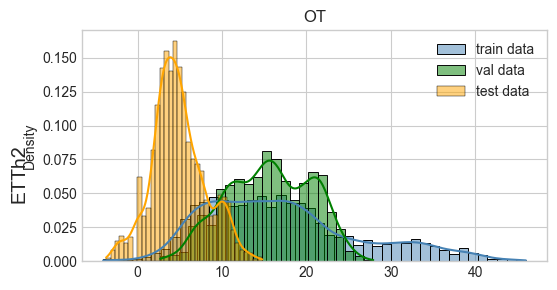

In [68]:
col = "OT"

plt.figure(figsize=(6, 3))
sns.histplot(train_data[col], color='steelblue', kde=True,
             stat='density', alpha=0.5, label='train data')
sns.histplot(val_data[col], color='green', kde=True,
             stat='density', alpha=0.5, label='val data')
sns.histplot(test_data[col], color='orange', kde=True,
             stat='density', alpha=0.5, label='test data')
plt.legend()
plt.xlabel('')
plt.ylabel('Density')
plt.title(col)
plt.suptitle("ETTh2", fontsize=14, x=0.02, y=0.5, rotation=90)
# plt.tight_layout()
plt.show()